In [1]:
# https://data-analysis-stats.jp/%E6%B7%B1%E5%B1%9E%E5%AD%A6%E7%BF%92/keras-autoencoder-%E3%81%A7%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5%E3%80%8C%E8%A9%90%E6%AC%BA%E6%A4%9C%E7%9F%A5%E3%80%8D/
# https://qiita.com/tk-tatsuro/items/10e9dbb3f2cf030e2119
!pip install lightGBM


In [2]:
from pathlib import Path
import warnings
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
import scipy.stats
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# CSVファイルを読み込む
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
print("train_data;",len(train))
print("test_data;",len(test))

train_data; 3489
test_data; 3489


In [3]:
# trainデータとtestデータをミックスしている。
# 特長量エンジニアリングを別々にやるのは面倒なので、ここで合体させて、学習時に分けるようにしていると思われる。賢い。
def merge_train_test(df_train, df_test):
    if "ProdTaken" not in df_test.columns.tolist():
        df_test["ProdTaken"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

# 合体させたときにgenre=-100にしているので、それを起点にtrainデータとtestデータを分ける。
def split_train_test(df):
    df_train = df[df["ProdTaken"] != -100]
    df_test = df[df["ProdTaken"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

In [4]:
# 特長量生成

# merge_data['Count'] = 1 # 利用回数の列を追加し、値を1とする
# daily_usage_per_customer = merge_data.groupby(['Date', 'CUSTOMER_ID'])['Count'].sum() # 顧客IDごとに日付ごとの利用回数を合計して、1日の利用回数を計算

# #上記mergeとdaily_usage_per_customerを結合
# left_DataFrame = merge_data
# right_DataFrame = daily_usage_per_customer
# merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',on=["CUSTOMER_ID","Date"], suffixes=('_x', '_total'))

# merge_data['daily_usage-mean_nb_tx_per_day'] = merge_data.apply(lambda row: row['Count_total'] - row['mean_nb_tx_per_day'], axis=1) #１日の利用回数－平均の利用回数
# merge_data = merge_data.drop(['Count_x','Count_total'], axis=1) #'count' 列を削除
# # print(merge_data)

In [5]:
# #距離計算
# #関数√(x_cus-x_ter)^2
# import numpy as np
# def func(row):
#     return np.sqrt((row['x_customer_id'] - row['x_terminal_id'])**2) + np.sqrt((row['y_customer_id'] - row['y_terminal_id'])**2)

# #上記関数関数当てはめ
# merge_data['distance'] = merge_data.apply(func, axis=1)
# # print(merge_data)

In [6]:
# merge_data['TX_AMOUNT-mean'] = merge_data.apply(lambda row: row['TX_AMOUNT'] - row['mean_amount'], axis=1)
# merge_data.describe()

In [7]:
# #端末ごとと異常率
# # ピボットテーブルを作成し、計算
# pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='TERMINAL_ID',aggfunc='count')
# pivot_table_total =pivot_table.reset_index()
# # ピボットテーブルを作成し、計算
# pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='TERMINAL_ID',aggfunc='sum')
# pivot_table_fraud =pivot_table.reset_index()
# pivot_table2 = pd.merge(pivot_table_total, pivot_table_fraud, how='left',left_on="TERMINAL_ID", right_on="TERMINAL_ID",suffixes=('_total', '_fraud'))
# pivot_table2['per_terminal'] = pivot_table2.apply(lambda row: row['TX_FRAUD_fraud'] / row['TX_FRAUD_total'], axis=1)
# pivot_table2 = pivot_table2.drop(['TX_FRAUD_total', 'TX_FRAUD_fraud'], axis=1) #'count' 列を削除
# left_DataFrame = merge_data
# right_DataFrame = pivot_table2
# merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',on='TERMINAL_ID', suffixes=('_x', '_y'))
# # print(merge_data)
# print(merge_data.columns.tolist())

In [8]:
# #顧客ごとの異常率
# # ピボットテーブルを作成し、計算
# pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='CUSTOMER_ID',aggfunc='count')
# pivot_table_total =pivot_table.reset_index()
# # ピボットテーブルを作成し、計算
# pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='CUSTOMER_ID',aggfunc='sum')
# pivot_table_fraud =pivot_table.reset_index()
# pivot_table2 = pd.merge(pivot_table_total, pivot_table_fraud, how='left',left_on="CUSTOMER_ID", right_on="CUSTOMER_ID",suffixes=('_total', '_fraud'))
# pivot_table2['per_customer'] = pivot_table2.apply(lambda row: row['TX_FRAUD_fraud'] / row['TX_FRAUD_total'], axis=1)
# pivot_table2 = pivot_table2.drop(['TX_FRAUD_total', 'TX_FRAUD_fraud'], axis=1) #'count' 列を削除
# left_DataFrame = merge_data
# right_DataFrame = pivot_table2
# merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',on='CUSTOMER_ID', suffixes=('_x', '_y'))
# # print(merge_data)
# print(merge_data.columns.tolist())

In [9]:
train.info()
# print(merge_data.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3389 non-null   object 
 2   TypeofContact           3483 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3368 non-null   object 
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3456 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3467 non-null   object 
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [10]:
# 0   id                      3489 non-null   int64  
#  1   Age                     3389 non-null   object 
# 年齢。欠損している。いい感じに補完したり、欠損値を新たな特長量としたい。
#  2   TypeofContact           3483 non-null   object 
# 顧客への連絡・接触方法　種類と、意味を理解して新たな特長量にできるか？
#  3   CityTier                3489 non-null   int64  
# 顧客の住んでいる都市のランク。1が最高ランク。欠損値なし。
#  4   DurationOfPitch         3368 non-null   object 
# 顧客へのプレゼンテーションの時間。欠損値あり。長さと満足度、成約率の関係性を見たい。
#  5   Occupation              3489 non-null   object 
# 顧客の職業。欠損値なし。職業と成約率の関係性を見たい。あと、どんな種類があるのか。
#  6   Gender                  3489 non-null   object 
# 顧客の性別
#  7   NumberOfPersonVisiting  3489 non-null   float64
# 予定している旅行の同行者の数
#  8   NumberOfFollowups       3456 non-null   float64
# 顧客へのフォローアップの回数。満足度や成約率との相関を見たい。
#  9   ProductPitched          3489 non-null   object 
# 顧客に提案された商品。種類と、成約率の関係性を見たい。
#  10  PreferredPropertyStar   3489 non-null   float64
# 顧客が好むホテルの星の数。欠損値なし。
#  11  NumberOfTrips           3467 non-null   object 
# 顧客が過去に旅行した回数。欠損値あり。旅行回数と成約率の関係性を見たい。
#  12  Passport                3489 non-null   int64  
# パスポートを持っているか。欠損値なし。
#  13  PitchSatisfactionScore  3489 non-null   int64  
# プレゼンテーションの満足度。欠損値なし。
#  14  Designation             3489 non-null   object 
# 顧客の役職。欠損値なし。役職と成約率の関係性を見たい。
#  15  MonthlyIncome           3433 non-null   object 
# 顧客の月収。欠損値あり。収入と成約率の関係性を見たい。
#  16  customer_info           3489 non-null   object 
# 顧客情報。欠損値なし。情報の種類と、成約率の関係性を見たい。
#  17  ProdTaken               3489 non-null   int64  
# 成約したかどうか。0が未成約、1が成約。欠損値なし。


In [11]:
df = merge_train_test(train, test)
df.isnull().sum()


id                          0
Age                       193
TypeofContact              18
CityTier                    0
DurationOfPitch           252
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups          57
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              64
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome             105
customer_info               0
ProdTaken                   0
dtype: int64

In [12]:
# それぞれの特徴量のユニークを可視化し、特徴量を前処理する
# df["Age"].unique()
# 入力がバラバラなので、数値に変換する
# すべての年齢に歳がついているので、最後の位置文字を取り除く
df["Age"] = df["Age"].str[:-1]
# 半角数字、nanはそのままとして、全角数字だった場合半角数字に変換する。漢字の数字は変換できないのでそのままとする。
# 全角数字を半角数字に変換する関数
def zenkaku_to_hankaku(s):
    return s.translate(str.maketrans('０１２３４５６７８９', '0123456789'))

# 全角漢数字を半角数字に変換する関数
kanji_to_num = {
    '一': '1', '二': '2', '三': '3', '四': '4', '五': '5',
    '六': '6', '七': '7', '八': '8', '九': '9', '〇': '0',
    '十': '10', '百': '100', '千': '1000'
}

def kanji_to_hankaku(s):
    num = 0
    unit = 1
    temp = 0
    for char in s:
        if char in kanji_to_num:
            digit = kanji_to_num[char]
            # digitは文字列なので、intに変換する
            digit = int(digit)
            if digit >= 10:
                if temp == 0:
                    temp = 1
                num += temp * digit
                temp = 0
            else:
                temp = temp * 10 + digit
        else:
            return s  # 漢数字以外の文字が含まれている場合は変換しない
    num += temp
    return str(num)

# 変換を適用する関数
def convert_age(age):
    if pd.isna(age):
        return age
    age = str(age)
    age = zenkaku_to_hankaku(age)
    age = kanji_to_hankaku(age)
    try:
        return int(age)
    except ValueError:
        return age

# 変換を適用
df['Age'] = df['Age'].apply(convert_age)

df["Age"]


0       50.0
1       56.0
2        NaN
3       37.0
4       48.0
        ... 
6973    41.0
6974    44.0
6975    24.0
6976    25.0
6977    44.0
Name: Age, Length: 6978, dtype: float64

In [13]:
df["customer_info"].unique()

array(['未婚 車未所持 子供なし', '離婚済み,車あり,子供無し', '結婚済み、自動車未所有,子供なし', ...,
       '離婚済み／車保有／子供有り(1人)', '結婚済み\t車未所持\t子供有り 3人',
       '未婚\u3000車なし\u3000子供3人'], dtype=object)

In [14]:
# NumberOfTripsの前処理。
# 変換マッピングを作成
mapping = {
    '年に1回': 1,
    '年に2回': 2,
    '年に3回': 3,
    '年に4回': 4,
    '年に5回': 5,
    '年に6回': 6,
    '年に7回': 7,
    '年に8回': 8,
    '半年に1回': 2,  # 半年に1回は年に2回
    '四半期に1回': 4  # 四半期に1回は年に4回
}

# 変換関数を定義
def convert_trips(value):
    if pd.isna(value):
        return np.nan
    if value in mapping:
        return mapping[value]
    try:
        return int(value)
    except ValueError:
        return np.nan
# 変換を適用
df["NumberOfTrips"] = df["NumberOfTrips"].apply(convert_trips)
df["NumberOfTrips"].unique()
df["NumberOfPersonVisiting"].unique()



array([1., 2., 3., 4.])

In [15]:
# DurationOfPitchの前処理。秒に変換する。
df["DurationOfPitch"].unique()
# 秒のものは秒までを取り出す。分のものは秒に変換する。
def convert_duration(duration):
    if pd.isna(duration):
        return duration
    duration = str(duration)
    if "秒" in duration:
        # 秒のものは秒までを取り出す
        return int(duration[:-1])
    if "分" in duration:
        return int(duration[:-1]) * 60
    return duration

df["DurationOfPitch"] = df["DurationOfPitch"].apply(convert_duration)
df["DurationOfPitch"]

0        900.0
1        840.0
2        600.0
3       1080.0
4       1020.0
         ...  
6973     840.0
6974    2100.0
6975    1260.0
6976     540.0
6977     480.0
Name: DurationOfPitch, Length: 6978, dtype: float64

In [16]:
# 年齢の処理。男性が1、女性が0に変換する。
df["Gender"].unique()
# m、M、ｍ、Ｍを男性に、f、F、ｆ、Ｆを女性に変換する。
# 文字列が全角だったら半角に変換する。
def zenkaku_to_hankaku(s):
    return s.translate(str.maketrans('ｍｆＭＦMF', 'mfmfmf'))

def gender_to_int(s):
    num = 0
    unit = 1
    temp = 0
    for char in s:
        if char == "m":
            return 1
        if char == "f":
            return 0
        return s
    return str(num)

# 変換を適用する関数
def convert_gender(gender):
    if pd.isna(gender):
        return gender
    gender = str(gender)
    gender = zenkaku_to_hankaku(gender)
    gender = gender_to_int(gender)
    try:
        return int(gender)
    except ValueError:
        return gender
    
df["Gender"] = df["Gender"].apply(convert_gender)
# 最初の文字がmだったら1、fだったら0に変換する。

df["Gender"].head()


def zenkaku_to_hankaku_pp(s):
    zenkaku = 'ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ０１２３４５６７８９'
    hankaku = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789'
    table = str.maketrans(zenkaku, hankaku)
    
    return s.translate(str.maketrans(table))

def pp_to_int(s):
    if s[0] == "b":
        re= 0
    elif s[0] == "s":
        re= 1
    elif s[0] == "d":
        re = 2
    elif s[0] == "k":
        re = 3
    elif s[0] == "B":
        re = 0
    elif s[0] == "S":
        re = 1
    elif s[0] == "D":
        re = 2
    elif s[0] == "K":
        re = 3
    elif s[0] == "ᗞ":
        re = 2
    elif s[0] == "Ꭰ":
        re = 2
    elif s[0] == "В":
        re = 0
    elif s[0] == "ꓢ":
        re = 1
    elif "Β" in s:
        re = 0
    elif "𐊡" in s:
        re = 0
    elif "Ѕ" in s:
        re = 1
    elif "Տ" in s:
        re = 1
    elif "𝙳" in s:
        re = 2
    else:
        print(s[0])
        re = -100
    return re

def designation_to_int(s):
    if "E" == s[0]:
        re = 0
    elif "S" == s[0]:
        re = 1
    elif "Ѕ" == s[0]:
        re = 1
    elif "Տenior" in s:
        re = 1
    elif "A" == s[0]:
        re = 2
    elif "А" in s:
        re = 2
    elif "M" == s[0]:
        re = 3
    elif "Μ" == s[0]:
        re = 3
    elif "V" == s[0]:
        re = 4
    elif "Е" == s[0]:
        re = 0
    elif "ΑVP" in s:
        re = 2    

    else:
        print(s)
        re = -100
    return re

# 変換を適用する関数
def convert_pp(pp):
    if pd.isna(pp):
        return pp
    pp = str(pp)
    pp = zenkaku_to_hankaku_pp(pp)
    pp = pp_to_int(pp)
    try:
        return int(pp)
    except ValueError:
        return pp
df["ProductPitched"] = df["ProductPitched"].apply(convert_pp)
df["ProductPitched"].unique()
# 0がBasic、1がStandard、2がDeluxe、3がKing

def convert_designation(designation):
    if pd.isna(designation):
        return designation
    designation = str(designation)
    designation = zenkaku_to_hankaku_pp(designation)
    designation = designation_to_int(designation)
    try:
        return int(designation)
    except ValueError:
        return designation
    
# Exective:0, Senior Manager:1, AVP:2, Manager:3、VP:4
df["Designation"] = df["Designation"].apply(convert_designation)
df["Designation"].unique()
    

array([0, 1, 2, 3, 4])

In [17]:
# MonthlyIncome
def convert_monthincome(monthincome):
    if pd.isna(monthincome):
        return monthincome
    monthincome = str(monthincome)
    if "月" in monthincome:
        # 月収万円を省略
        monthincome = monthincome[2:-2]
        monthincome = float(monthincome)  * 10000
    try:
        return float(monthincome)
    except ValueError:
        return monthincome
    
# Exective:0, Senior Manager:1, AVP:2, Manager:3、VP:4
df["MonthlyIncome"] = df["MonthlyIncome"].apply(convert_monthincome)
df["MonthlyIncome"].describe()

count      6873.000000
mean     356131.710316
std       76149.009367
min      200000.000000
25%      300000.000000
50%      342075.000000
75%      400000.000000
max      600000.000000
Name: MonthlyIncome, dtype: float64

In [18]:
# customer_info
import re
    
def classification(customer_info):
    print(customer_info)
    if "未婚" in str(customer_info[0]):
        married = 0
    elif "独身" in str(customer_info[0]):
        married = 0
    elif "離婚" in str(customer_info[0]):
        married = 2
    elif "結婚" in str(customer_info[0]):
        married = 1
    else:
        print(customer_info[0])

    if "車未所持" in str(customer_info[1]):
        has_car = 0
    elif "未所有" in str(customer_info[1]):
        has_car = 0
    elif "乗用車なし" in str(customer_info[1]):
        has_car = 0
    elif "自家用車なし" in str(customer_info[1]):
        has_car = 0
    elif "車なし" in str(customer_info[1]):
        has_car = 0
    elif "車あり" in str(customer_info[1]):
        has_car = 1
    elif "車所持" in str(customer_info[1]):
        has_car = 1
    elif "車保有" in str(customer_info[1]):
        has_car = 1
    elif "自動車所有" in str(customer_info[1]):
        has_car = 1
    else:
        print(customer_info[1])



    if "なし" in str(customer_info[2]):
        has_child = 0
    elif "無し" in str(customer_info[2]):
        has_child = 0
    elif "無子" in str(customer_info[2]):
        has_child = 0
    elif "子供ゼロ" in str(customer_info[2]):
        has_child = 0
        #非育児家庭は別の変数にするのもあり？？
    elif "非育児家庭" in str(customer_info[2]):
        has_child = 0
    elif "子育て状況不明" in str(customer_info[2]):
        has_child = -1
    elif "子の数不詳" in str(customer_info[2]):
        has_child = -1
    elif "子供の数不明" in str(customer_info[2]):
        has_child = -1
    elif "わからない" in str(customer_info[2]):
        has_child = -1
    elif "不明" in str(customer_info[2]):
        has_child = -1
    elif "こども1人" in str(customer_info[2]):
        has_child = 1
    elif "1児" in str(customer_info[2]):
        has_child = 1
    elif "子供1人" in str(customer_info[2]):
        has_child = 1
    elif "子供有り(1人)" in str(customer_info[2]):
        has_child = 1
    elif "子供有り" in str(customer_info[2]):
        has_child = 1
    elif "こども2人" in str(customer_info[2]):
        has_child = 2
    elif "子供2人" in str(customer_info[2]):
        has_child = 2
    elif "2児" in str(customer_info[2]):
        has_child = 2
    elif "こども3人" in str(customer_info[2]):
        has_child = 2
    elif "子供3人" in str(customer_info[2]):
        has_child = 3
    elif "3児" in str(customer_info[2]):
        has_child = 3
    else:
        print(customer_info[2])


    return married, has_car, has_child


def split(text):
    # カンマで囲まれている場合は削除する

    if (text.startswith("'") and text.endswith("'")) or (text.startswith('"') and text.endswith('"')):
        text = text[1:-1]
    text = re.sub(r"^['\"]|['\"]$", '', text)
    # 得られた文字列をカンマ、全角カンマ、スペース、全角スペースで分割する
    text = re.split(r',|、| |　|／|/|\t|\n', text)
    # print(text)
    return text
    



# 変換を適用する関数
def convert_customer_info(customer_info):
    if pd.isna(customer_info):
        return customer_info
    customer_info = str(customer_info)
    customer_info = split(customer_info)
    married, has_car, has_child = classification(customer_info)
    try:
        return int(married),int(has_car), int(has_child)
    except ValueError:
        return married, has_car, has_child
    
df["customer_info"] = df["customer_info"].apply(convert_customer_info)
# 最初の文字がmだったら1、fだったら0に変換する。

# df["customer_info"]のうち最初の要素を取り出して新たな特長量とする。
df["customer_info_marry"] = df["customer_info"].apply(lambda x: x[0])
df["customer_info_has_car"] = df["customer_info"].apply(lambda x: x[1])
df["customer_info_has_child"] = df["customer_info"].apply(lambda x: x[2])

df["customer_info_marry"].unique()


['未婚', '車未所持', '子供なし']
['離婚済み', '車あり', '子供無し']
['結婚済み', '自動車未所有', '子供なし']
['離婚済み', '車所持', '子供無し']
['独身', '車所持', '無子']
['独身', '車未所持', '子供ゼロ']
['独身', '自家用車あり', '子供なし']
['結婚済み', '車未所持', '子供なし']
['独身', '車未所持', '子供無し']
['結婚済み', '車所持', '非育児家庭']
['未婚', '車保有', '子供なし']
['離婚済み', '車あり', '子供なし']
['独身', '車所持', '子供なし']
['結婚済み', '車所持', '非育児家庭']
['独身', '車所持', '無子']
['独身', '車所持', '子供なし']
['独身', '車未所持', '子供なし']
['未婚', '車所持', '子供無し']
['結婚済み', '自動車未所有', '子供無し']
['結婚済み', '自動車未所有', '子供なし']
['未婚', '車保有なし', '子供なし']
['離婚済み', '乗用車所持', '子供なし']
['離婚済み', '自動車未所有', '子供なし']
['結婚済み', '車あり', '子供無し']
['離婚済み', '車所持', '子供なし']
['結婚済み', '乗用車なし', '子供なし']
['独身', '車所持', '子供なし']
['未婚', '自動車所有', '子供なし']
['結婚済み', '自家用車あり', '子供なし']
['独身', '車未所持', '子供なし']
['結婚済み', '車未所持', '子供無し']
['離婚済み', '自動車所有', '子供なし']
['未婚', '車所持', '子供なし']
['結婚済み', '自動車未所有', '子供なし']
['独身', '車未所持', '子供なし']
['独身', '車保有', '子供無し']
['独身', '車所持', '子供ゼロ']
['未婚', '車未所持', '子供なし']
['未婚', '車所持', '子供無し']
['結婚済み', '車所持', '無子']
['結婚済み', '自動車未所有', '子供無し']
['独身', '自家用車あり', '子

array([0, 2, 1])

In [19]:


columns_label_enc = ["TypeofContact","Occupation","CityTier","NumberOfPersonVisiting"]
for col in columns_label_enc:
    # regionのラベルエンコーディングを行っている。
    # ラベルエンコーディングとは、カテゴリ変数を数値に変換すること。ワンホットエンコーディングと違い、数値が大小関係を持つため、モデルが大小関係を学習できる。どちらかを採用すること。
    df[col] = LabelEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, col] = np.nan
df["CityTier"].unique()


array([1., 0., 2.])

In [20]:
df["num_nans"] = 0
for col in [
    "Age",
    "TypeofContact",
    "DurationOfPitch",
    "NumberOfFollowups",
    "NumberOfTrips",
    "MonthlyIncome",
]:
    df["num_nans"] += df[col].isna()

In [21]:
# 今回は欠損値が多いので、欠損値の列を目的変数として、欠損値の値を予測するモデルを作成する。

df.isnull().sum()
# nullがあるcolumnを取得する
null_columns = df.columns[df.isnull().sum() > 0]
print(null_columns)
null_columns = ['Age',"DurationOfPitch","NumberOfFollowups","NumberOfTrips","MonthlyIncome",
                'TypeofContact','NumberOfPersonVisiting','ProductPitched','PreferredPropertyStar','Designation',]

features = ["Age","TypeofContact","DurationOfPitch","Gender","NumberOfFollowups","NumberOfTrips","PitchSatisfactionScore","MonthlyIncome","Passport",
            "Designation","PreferredPropertyStar","customer_info_marry","customer_info_has_car","customer_info_has_child",
            "num_nans","NumberOfPersonVisiting","ProductPitched","CityTier","Occupation",
            ]
# 学習に用いないデータ
not_features = ["id","ProdTaken","customer_info"]


for null_column in null_columns:
    # 欠損値を予測するモデルを作成する。テストデータは使用しないようにする。
    train_data, test_data = split_train_test(df)
    # 欠損値の行を取り出す。欠損値がない場合はスキップ
    if len(train_data[train_data[null_column].isnull()]) == 0:
        continue
    null_data = train_data[train_data[null_column].isnull()]
    # 欠損値のない行を学習データとして取り出す
    train_data_non_null = train_data.dropna(subset=[null_column])

    # featuresの特長量に限定する
    train_data_non_null = train_data_non_null[features]
    null_data = null_data[features]


    # 欠損値を予測するモデルをlightgbmで作成する
    # モデルの作成
    model = lgb.LGBMRegressor()
    # 特徴量と目的変数を取り出す
    X = train_data_non_null.drop(columns=null_column)
    y = train_data_non_null[null_column]
    # 学習
    model.fit(X, y)
    # 予測
    pred = model.predict(null_data.drop(columns=null_column))
    # null_dataに予測結果を代入し、train_data_non_nullと合わせて元のtrain_dataに戻す。
    null_data.loc[:, null_column] = pred
    # train_data_non_nullのnot_featuresを付け足す
    train_data_non_null = train_data_non_null.join(train_data[not_features])
    # null_dataのnot_featuresを付け足す
    null_data = null_data.join(train_data[not_features])
    train_data = pd.concat([train_data_non_null, null_data]).reset_index(drop=True)

    # test_dataでも同様に予測して予測値を代入する
    pred = model.predict(test_data[features].drop(columns=null_column))
    test_data.loc[:, null_column] = pred

    # dfにtrain_dataとtest_dataを結合する
    df = pd.concat([train_data, test_data]).reset_index(drop=True)

# dfにnanがあるか確認する
print(df.columns[df.isnull().sum() > 0])
# nanがあるものを抽出して出力する
null_data = df[df.isnull().sum(axis=1) > 0]
print(null_data)



Index(['Age', 'DurationOfPitch', 'NumberOfFollowups', 'NumberOfTrips',
       'MonthlyIncome'],
      dtype='object')
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 3389, number of used features: 18
[LightGBM] [Info] Start training from score 38.889938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 3368, number of used features: 18
[LightGBM] [Info] Start training from score 860.682898
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead 

In [22]:
# TypeofContactのone-hotエンコーディング、ついでにunknownの列名を変更している。
df = pd.concat([df, pd.get_dummies(df["TypeofContact"]).astype(int).rename(columns={np.nan: "TypeofContact_nan"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["Occupation"]).astype(int).rename(columns={np.nan: "Occupation_nan"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["CityTier"]).astype(int).rename(columns={1: "CityTier_1", 2: "CityTier_2", 0: "CityTier_3"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["NumberOfPersonVisiting"]).astype(int).rename(columns={1: "NumberOfPersonVisiting_1", 2: "NumberOfPersonVisiting_2", 3: "NumberOfPersonVisiting_3", 0: "NumberOfPersonVisiting_4"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["ProductPitched"]).astype(int).rename(columns={0: "ProductPitched_0", 1: "ProductPitched_1", 2: "ProductPitched_2", 3: "ProductPitched_3"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["PreferredPropertyStar"]).astype(int).rename(columns={3: "PreferredPropertyStar_3", 4: "PreferredPropertyStar_4", 5: "PreferredPropertyStar_5"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["Passport"]).astype(int)], axis=1).rename(columns={0: "Passport_0", 1: "Passport_1"})
df = pd.concat([df, pd.get_dummies(df["Designation"]).astype(int).rename(columns={0: "Designation_0", 1: "Designation_1", 2: "Designation_2", 3: "Designation_3", 4: "Designation_4"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["customer_info_marry"]).astype(int).rename(columns={0: "customer_info_marry_0", 1: "customer_info_marry_1", 2: "customer_info_marry_2"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["customer_info_has_car"]).astype(int).rename(columns={0: "customer_info_has_car_0", 1: "customer_info_has_car_1"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["customer_info_has_child"]).astype(int).rename(columns={0: "customer_info_has_child_0", 1: "customer_info_has_child_1", 2: "customer_info_has_child_2", 3: "customer_info_has_child_3", -1: "customer_info_has_child_-1"})], axis=1)
# TypeofContactは2値しかないのでカウントエンコーディングには向かない。


class CountEncoder:
    def fit(self, series):
        # "series"ごとの出現回数をカウント
        self.counts = series.groupby(series).count()
        return self

    def transform(self, series):
        # "series"の各要素を、fit時に集計した出現回数に置換
        return series.map(self.counts).fillna(0)

    def fit_transform(self, series):
        # fitとtransformをまとめて実行
        return self.fit(series).transform(series)
columns_count_enc = ["CityTier","NumberOfPersonVisiting","NumberOfFollowups","ProductPitched","NumberOfTrips","Passport","PitchSatisfactionScore","Designation","customer_info_marry","customer_info_has_car","customer_info_has_child"]
for col in columns_count_enc:
    # regionの出現回数をカウントして、新しい列を作成している。
    df["countenc_" + col] = CountEncoder().fit_transform(df[col])
    # 欠損値をnanに変換している。locはnanの行を取得している。
    df.loc[df[col].isna().values, "countenc_" + col] = np.nan


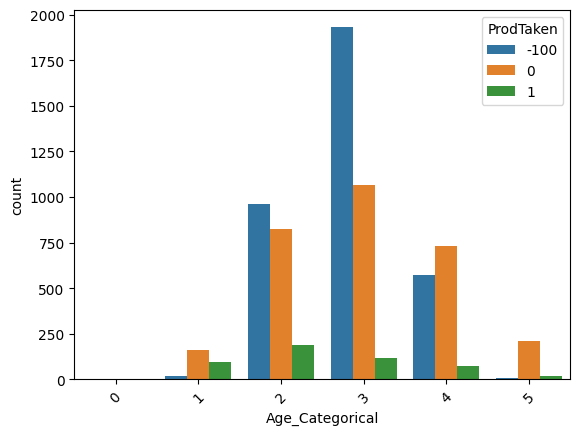

array([4, 5, 3, 1, 2, 0])

In [23]:
#特長量のカテゴリカル変数を作成する
# Ageを18歳未満、18-24歳、25-34歳、35-44歳、45-54歳、55-64歳、65-74歳、75歳以上に分け歳代を作成する。
df["Age_Categorical"] = pd.cut(df["Age"], bins=[0, 18, 25, 35, 45, 55, 65, 75, 100], right=False)
# 年代ごとの成約成功かどうかを可視化する
df["Age_Categorical"] = LabelEncoder().fit_transform(df["Age_Categorical"])
sns.countplot(x="Age_Categorical", hue="ProdTaken", data=df)
plt.xticks(rotation=45)
plt.show()
df["Age_Categorical"].unique()

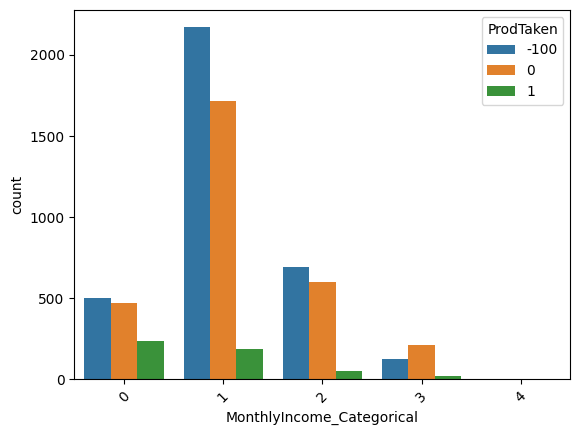

In [24]:
#特長量のカテゴリカル変数を作成する
# MonthlyIncomeを0-10万円、10-20万円、20-30万円、30-40万円、40-50万円、50-60万円、60-70万円、70-80万円、80-90万円、90-100万円、100万円以上に分け月収を作成する。
df["MonthlyIncome_Categorical"] = pd.cut(df["MonthlyIncome"], bins=[0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 100000000], right=False)
# 月収ごとの成約成功かどうかを可視化する
df["MonthlyIncome_Categorical"] = LabelEncoder().fit_transform(df["MonthlyIncome_Categorical"])
sns.countplot(x="MonthlyIncome_Categorical", hue="ProdTaken", data=df)
plt.xticks(rotation=45)
plt.show()



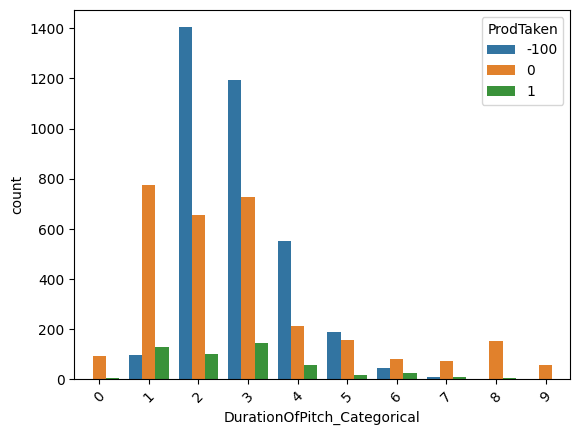

In [25]:
#特長量のカテゴリカル変数を作成する
# DurationOfPitchを0-100秒、100-200秒、200-300秒、300-400秒、400-500秒、500-600秒、600-700秒、700-800秒、800-900秒、900-1000秒、1000秒以上に分けプレゼンテーション時間を作成する。
df["DurationOfPitch_Categorical"] = pd.cut(df["DurationOfPitch"], bins=[0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000,2200, 2400, 100000000], right=False)
# プレゼンテーション時間ごとの成約成功かどうかを可視化する
df["DurationOfPitch_Categorical"] = LabelEncoder().fit_transform(df["DurationOfPitch_Categorical"])
sns.countplot(x="DurationOfPitch_Categorical", hue="ProdTaken", data=df)
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


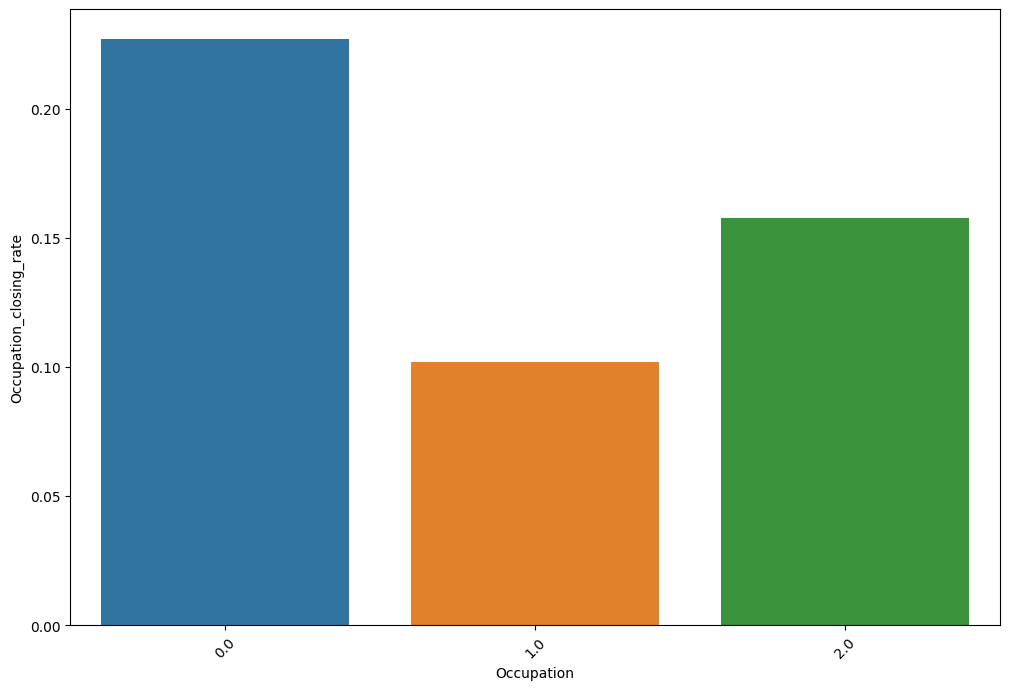

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


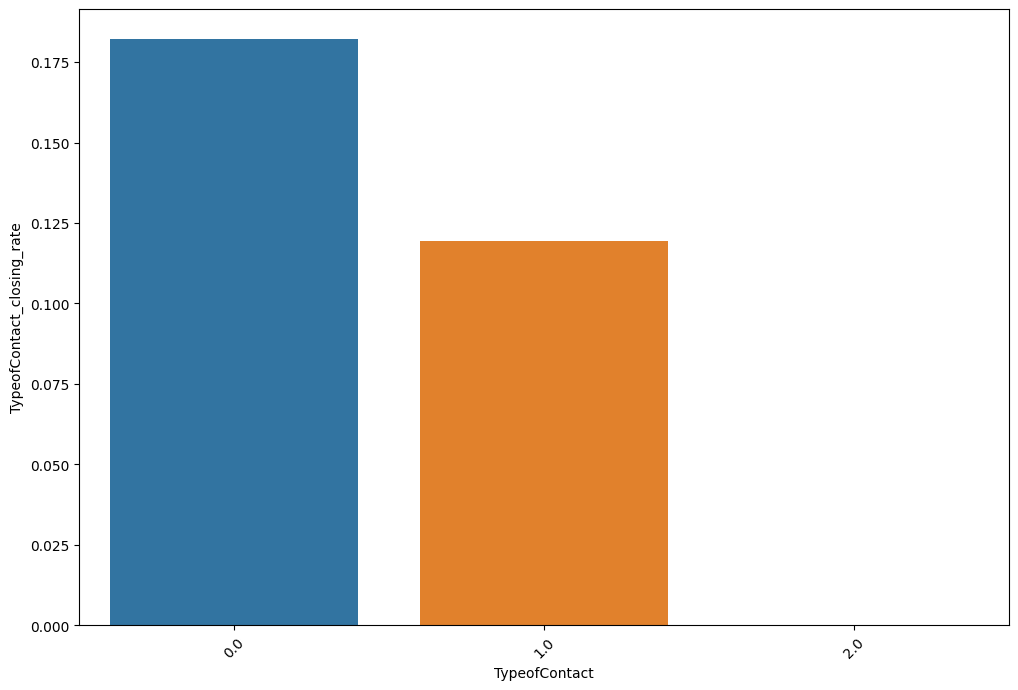

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


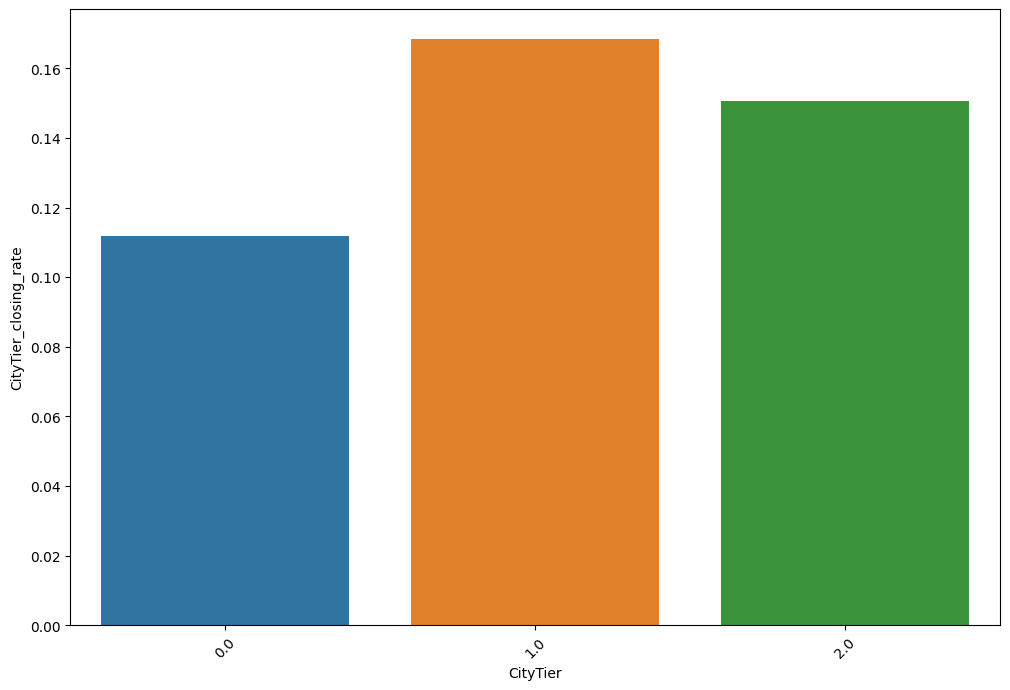

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


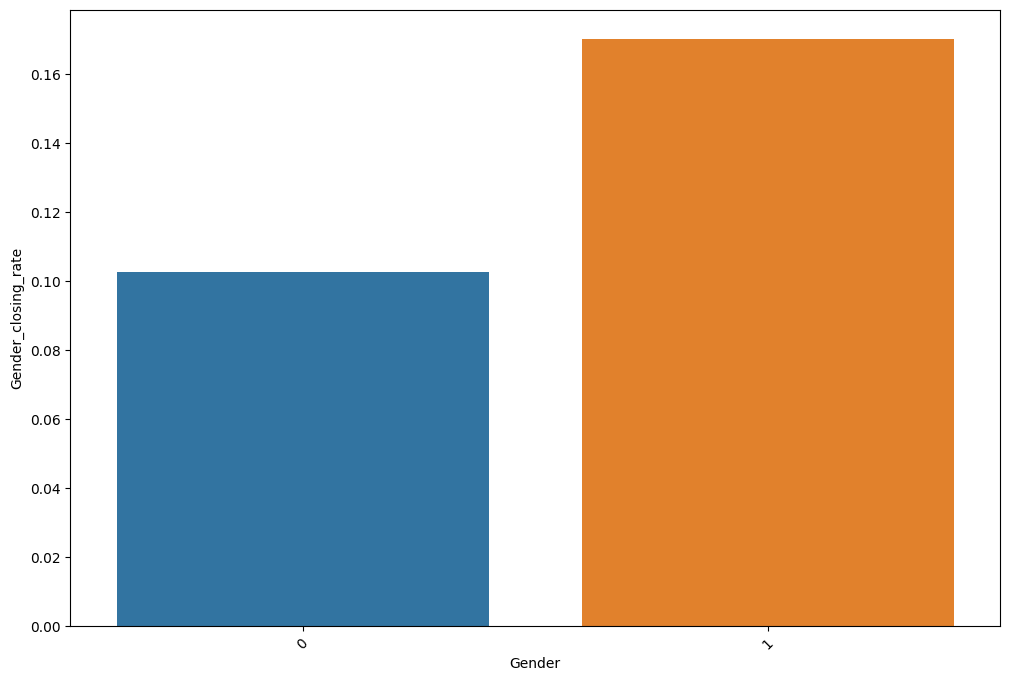

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


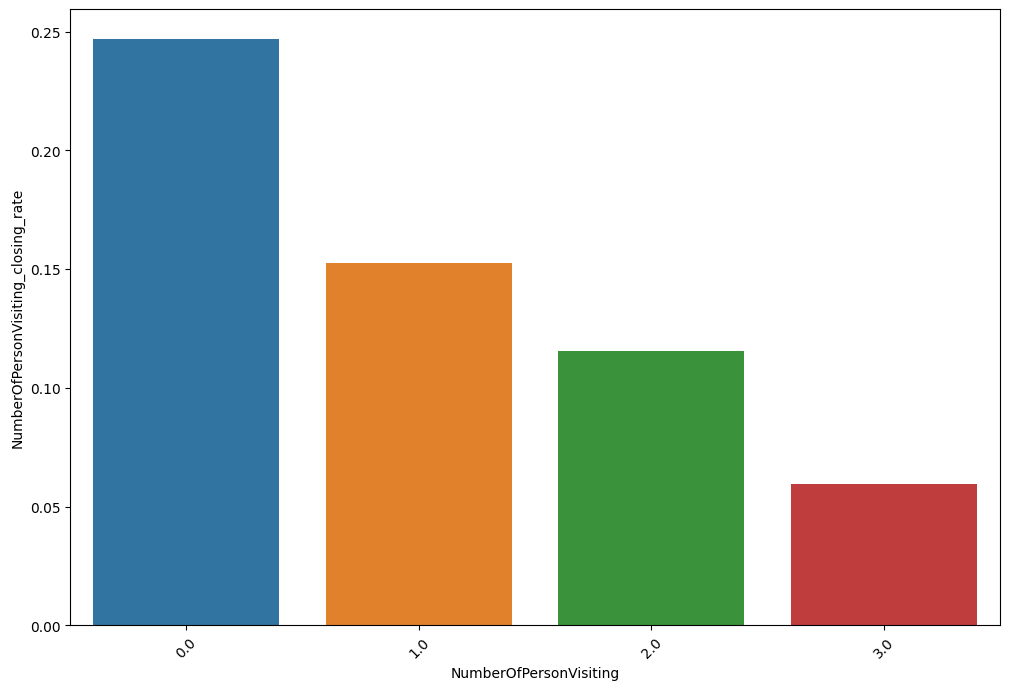

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


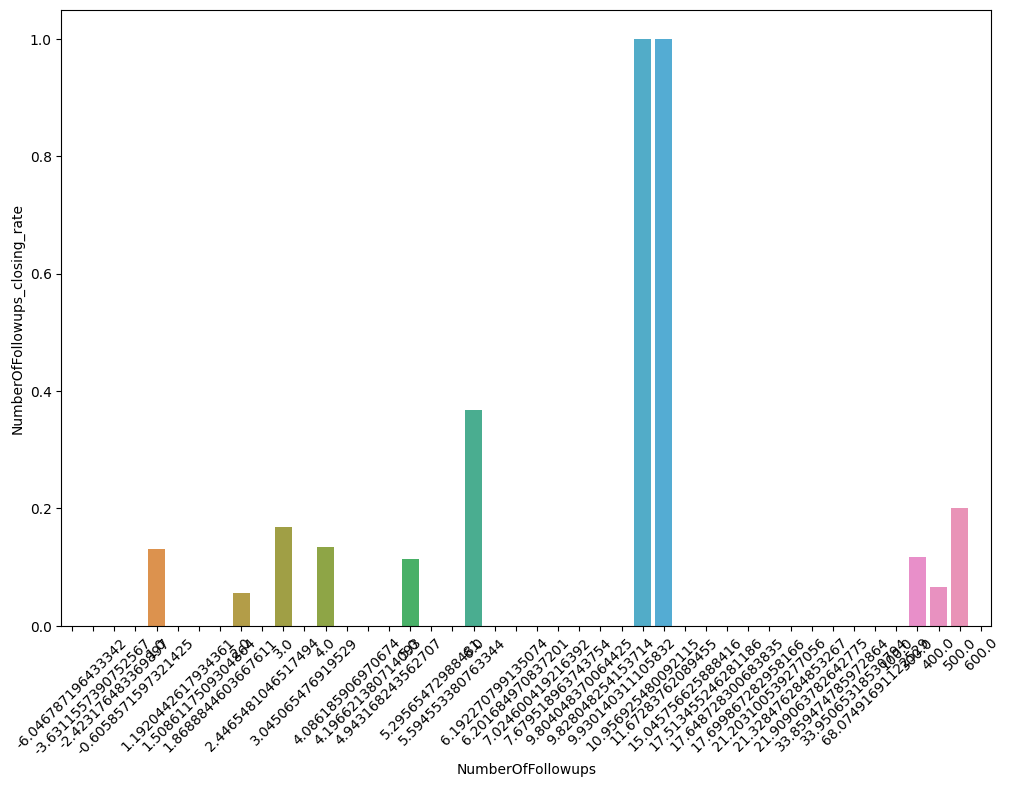

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


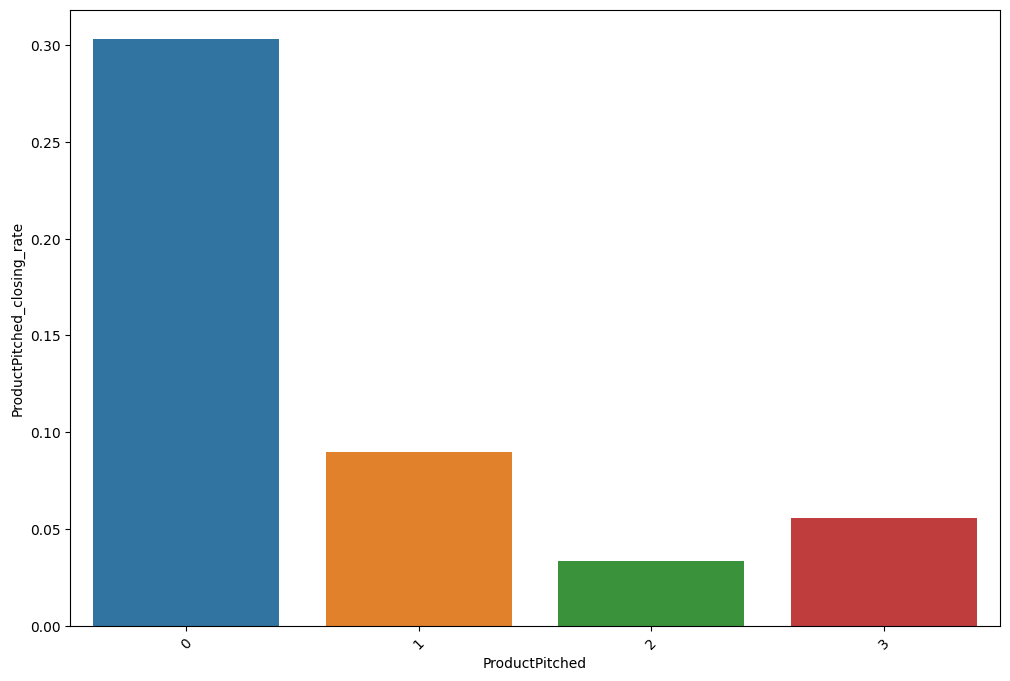

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


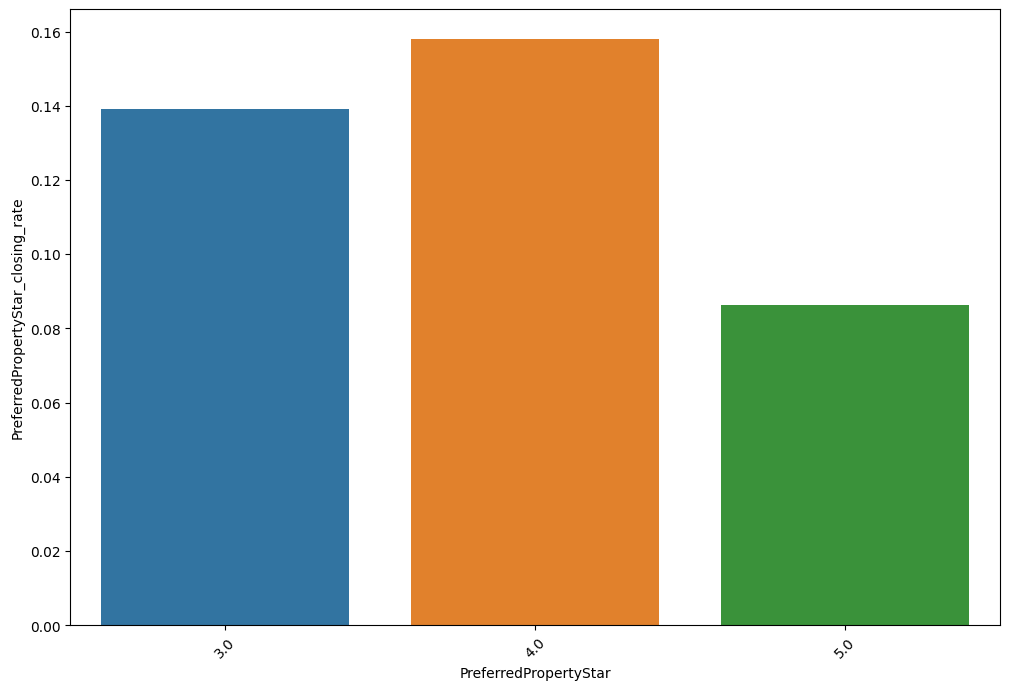

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


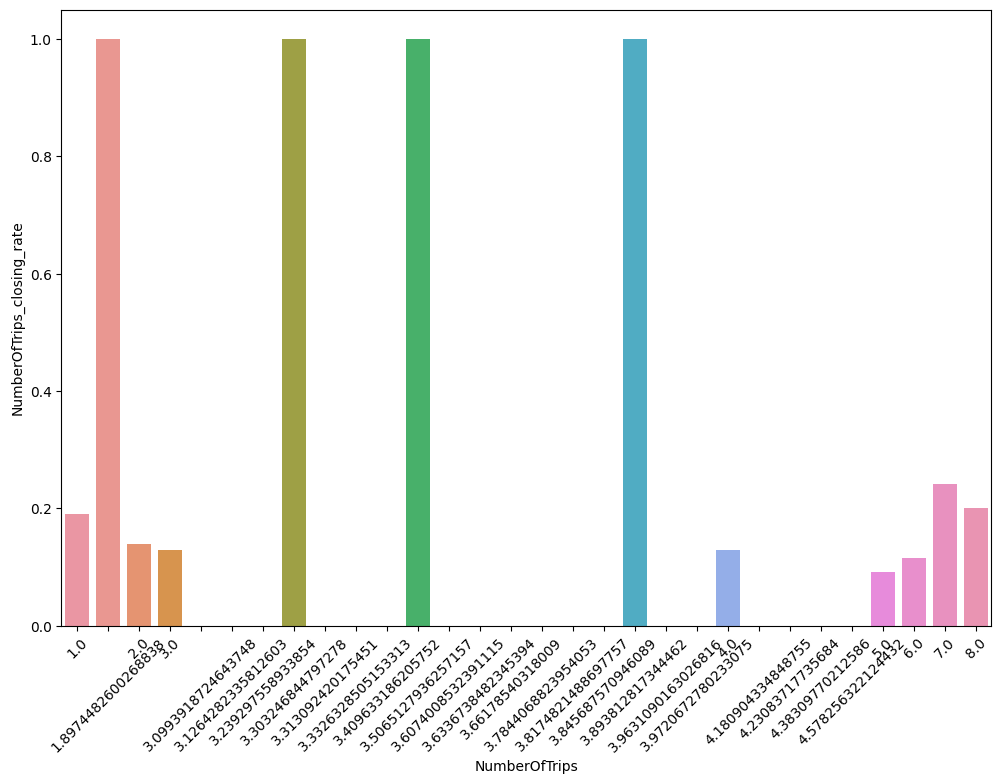

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


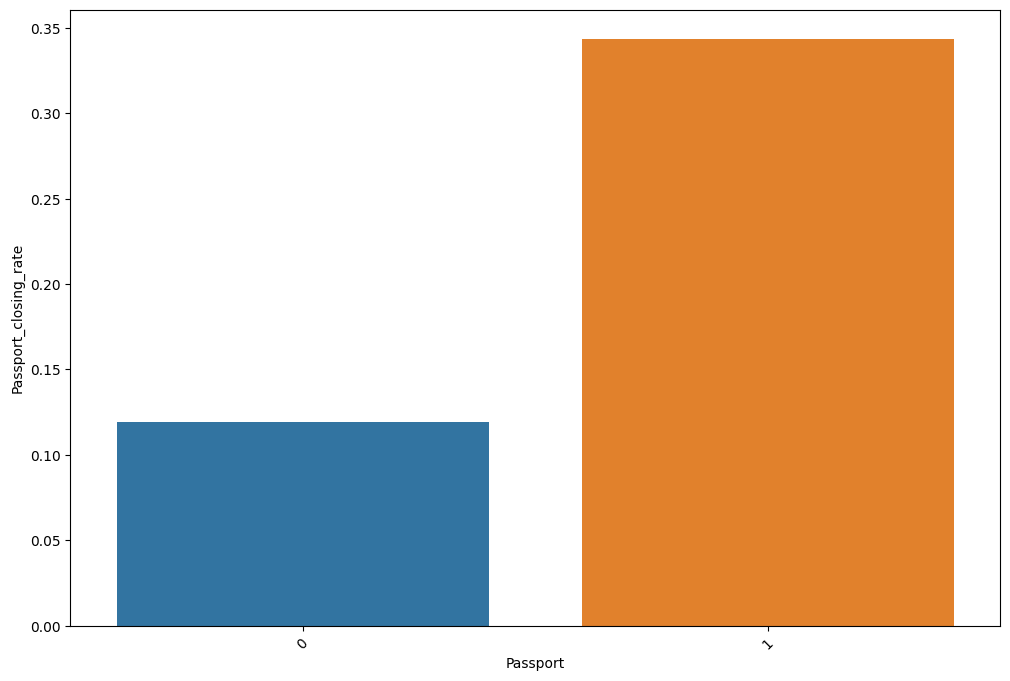

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


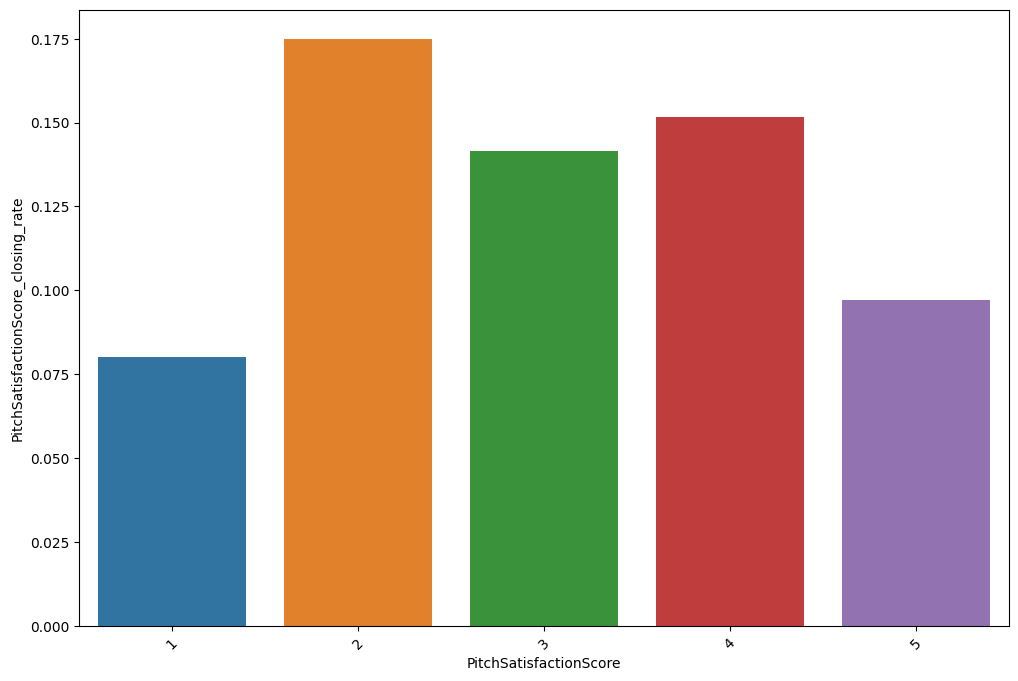

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


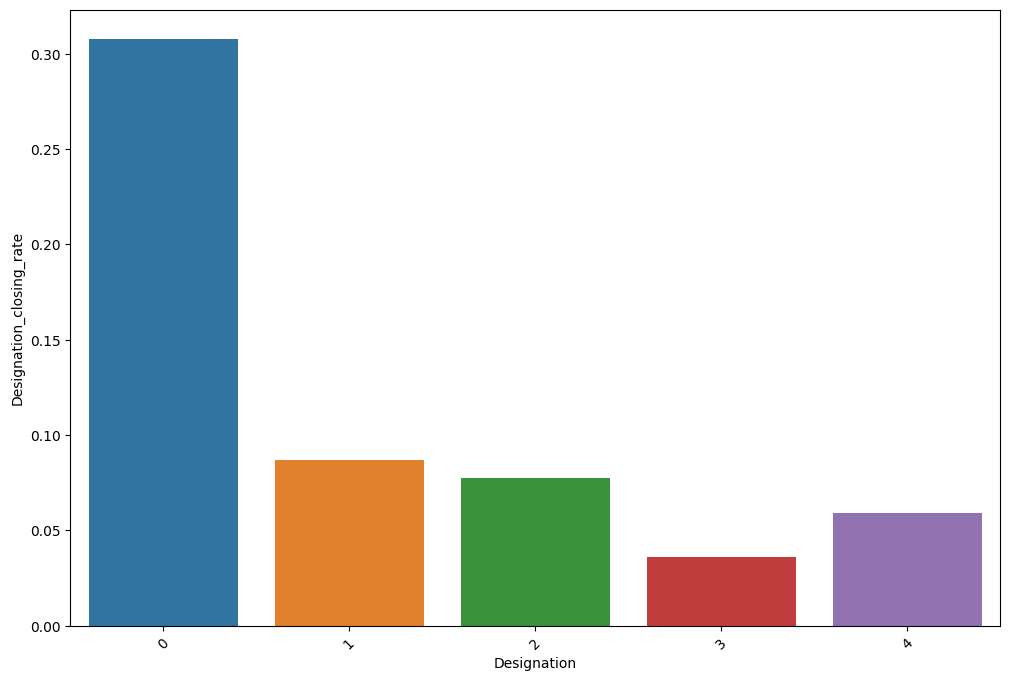

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


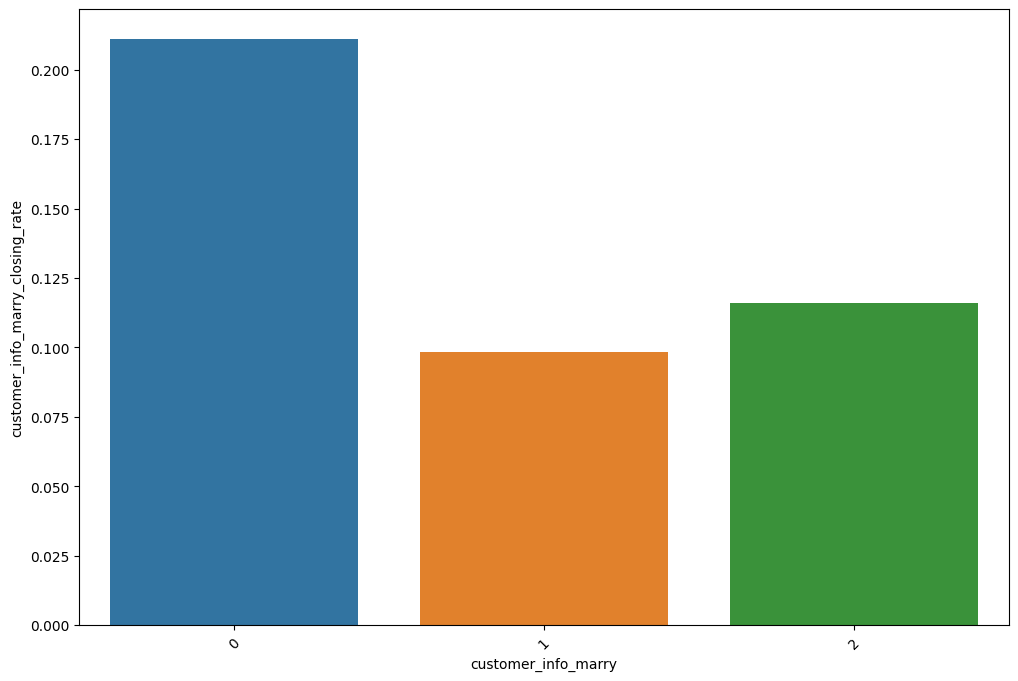

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


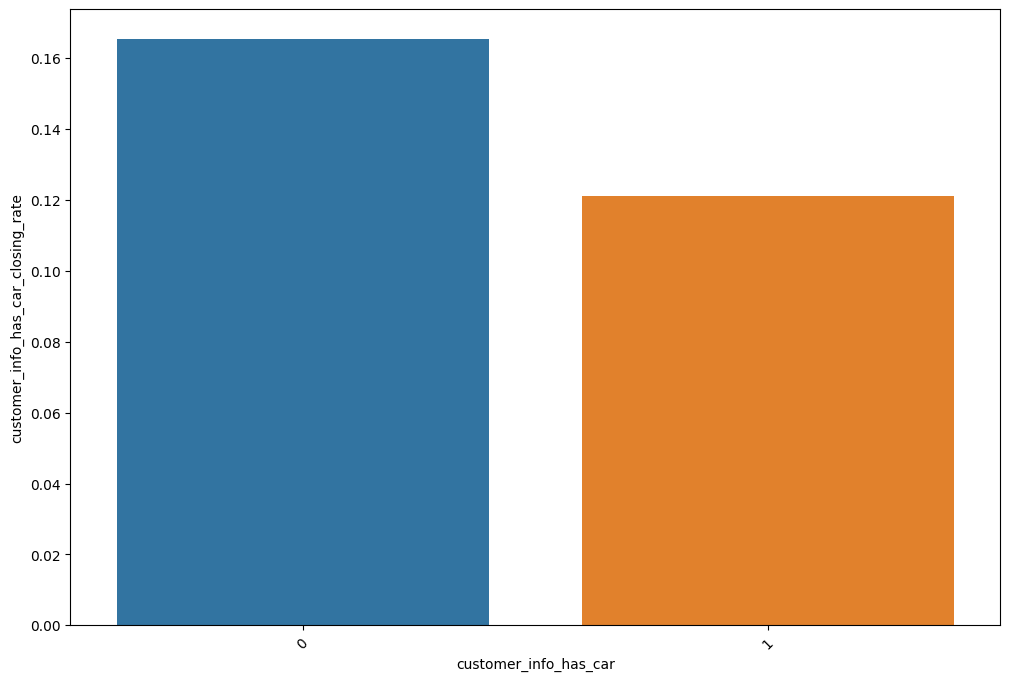

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


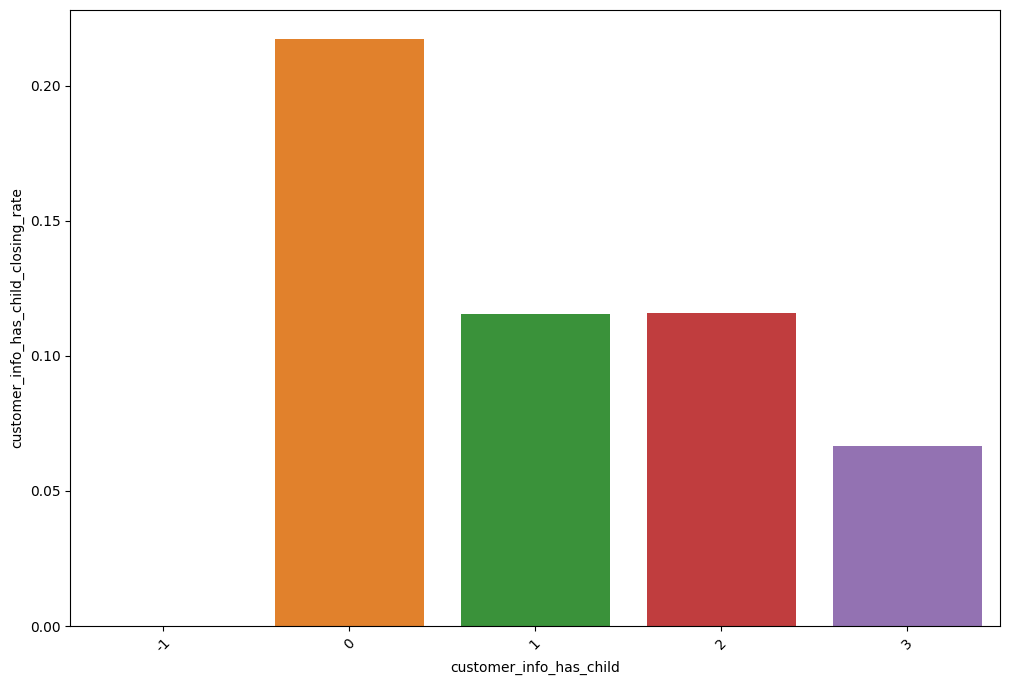

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


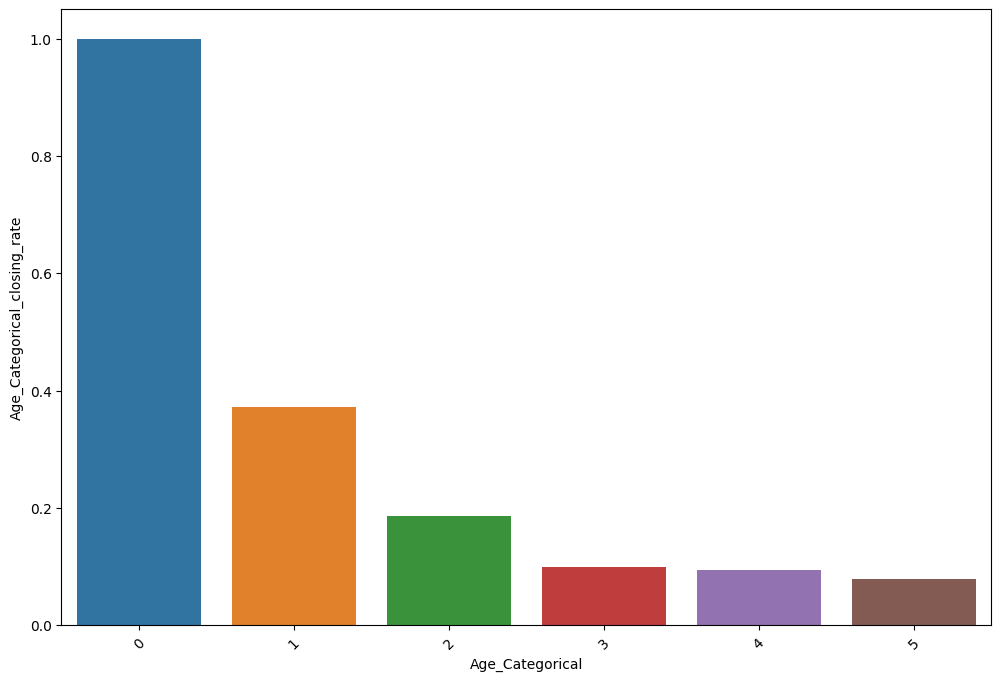

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


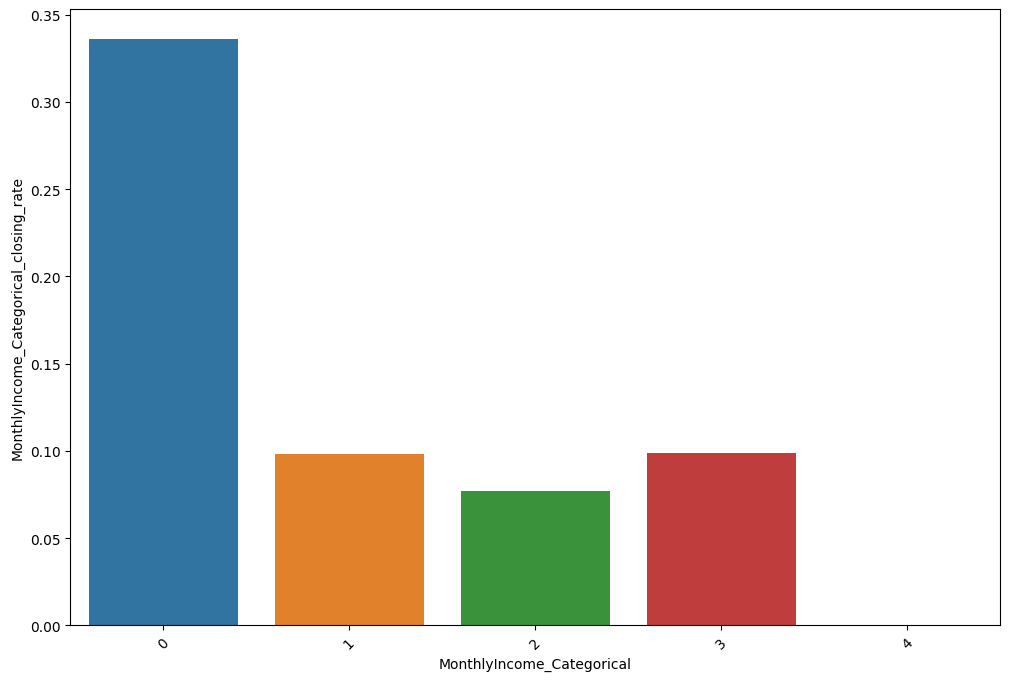

/tmp/ipykernel_17180/1927721550.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
/tmp/ipykernel_17180/1927721550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]


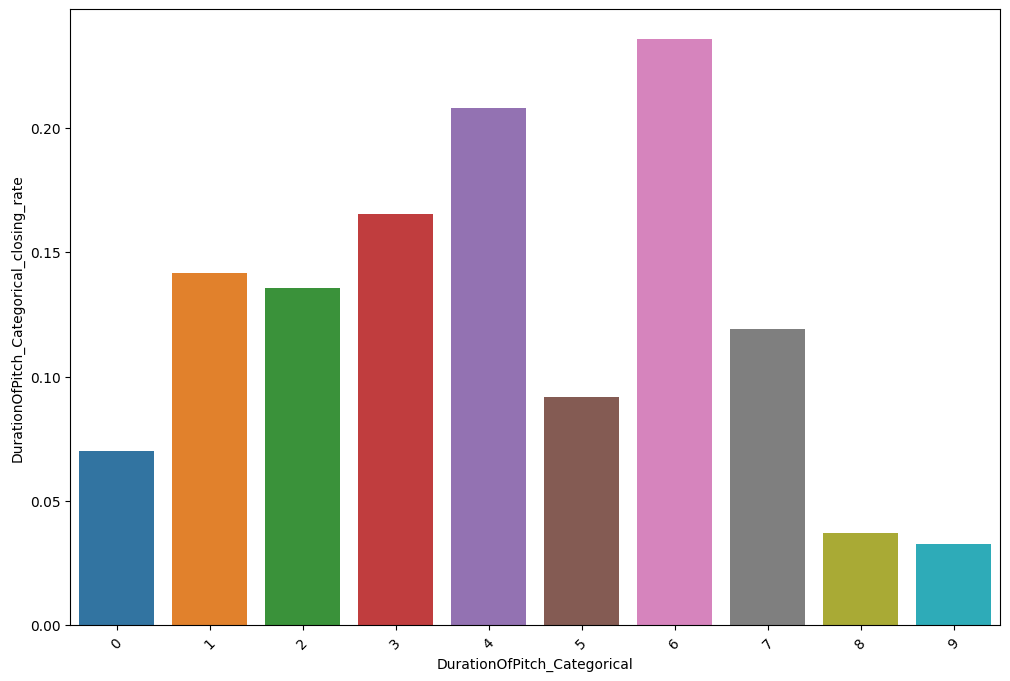

array([0., 1., 2., 3.])

In [26]:
# 特長量生成を行う
# 成約率を使用した特長生成を行ってみる
df_train_gen, df_test_gen = split_train_test(df)

def calculate_prodtaken_rate(df_train_gen,df_test_gen,columns):
    # 新たに作成した特長量名を格納するリスト
    new_columns = []
    for col in columns:
        # エラーが起きないようpivot_tableを初期化する
        pivot_table = pd.DataFrame()
        pivot_table = df_train_gen.pivot_table(values="ProdTaken", index=col, aggfunc="mean")
        pivot_table_fraud =pivot_table.reset_index()
        # ProdTaken_rate_col名で新しい列を作成する
        pivot_table2 = pd.merge(df_train_gen, pivot_table_fraud, how='left',left_on=col, right_on=col,suffixes=('_total','_rate'))
        df_train_gen[col + "_closing_rate"] = pivot_table2["ProdTaken_rate"]
        pivot_table3 = pd.merge(df_test_gen, pivot_table_fraud, how='left',left_on=col, right_on=col,suffixes=('_total','_rate'))
        df_test_gen[col + "_closing_rate"] = pivot_table3["ProdTaken_rate"]
        plt.figure(figsize=(12, 8))
        sns.barplot(x=col, y=col + "_closing_rate", data=df_train_gen)
        plt.xticks(rotation=45)
        plt.show()
        df_test_gen.head()
        new_columns.append(col + "_closing_rate")
    return df_train_gen,df_test_gen,new_columns 

columns = ["Occupation","TypeofContact","CityTier","Gender","NumberOfPersonVisiting",
           "NumberOfFollowups","ProductPitched","PreferredPropertyStar","NumberOfTrips","Passport",
              "PitchSatisfactionScore","Designation","customer_info_marry","customer_info_has_car",
                "customer_info_has_child",
           "Age_Categorical","MonthlyIncome_Categorical","DurationOfPitch_Categorical"
           ]
df_train_gen,df_test_gen, new_columns = calculate_prodtaken_rate(df_train_gen,df_test_gen,columns)

# 分離したデータを結合する
df = merge_train_test(df_train_gen, df_test_gen)
df["NumberOfPersonVisiting"].unique()


In [27]:
new_columns

['Occupation_closing_rate',
 'TypeofContact_closing_rate',
 'CityTier_closing_rate',
 'Gender_closing_rate',
 'NumberOfPersonVisiting_closing_rate',
 'NumberOfFollowups_closing_rate',
 'ProductPitched_closing_rate',
 'PreferredPropertyStar_closing_rate',
 'NumberOfTrips_closing_rate',
 'Passport_closing_rate',
 'PitchSatisfactionScore_closing_rate',
 'Designation_closing_rate',
 'customer_info_marry_closing_rate',
 'customer_info_has_car_closing_rate',
 'customer_info_has_child_closing_rate',
 'Age_Categorical_closing_rate',
 'MonthlyIncome_Categorical_closing_rate',
 'DurationOfPitch_Categorical_closing_rate']

In [28]:
# 成約率以外を使用して特長量を生成する
# カテゴリカル変数の組み合わせで新たな特長量を生成する

def create_categorical_combination(df):
    # 新たに作成した特長量名を格納するリスト
    new_columns = []
    generate_columns =["Age_Categorical","MonthlyIncome_Categorical","DurationOfPitch_Categorical",
                       "Occupation","CityTier","TypeofContact","NumberOfPersonVisiting",
                       "NumberOfFollowups","ProductPitched","PreferredPropertyStar","Designation","customer_info_marry",
                       "customer_info_has_car","customer_info_has_child","Gender","NumberOfTrips","Passport","PitchSatisfactionScore"]
    for col1 in generate_columns:
        for col2 in generate_columns:
            # col1とcol2が同一だった場合はスキップする
            if col1 == col2:
                continue
            # col1とcol2が逆順で既に作成済みの特長量がある場合はスキップする
            if col2 + "_" + col1 in new_columns:
                continue
            df[col1 + "_" + col2] = df[col1].astype(str) + "_" + df[col2].astype(str)
            df[col1 + "_" + col2] = LabelEncoder().fit_transform(df[col1 + "_" + col2])
            # sns.countplot(x=col1 + "_" + col2, hue="ProdTaken", data=df)
            # plt.xticks(rotation=45)
            # plt.show()
            new_columns.append(col1 + "_" + col2)
    return df, new_columns

df, new_columns_categorical_colob = create_categorical_combination(df)


/tmp/ipykernel_17180/1508795753.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col1 + "_" + col2] = df[col1].astype(str) + "_" + df[col2].astype(str)
/tmp/ipykernel_17180/1508795753.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col1 + "_" + col2] = df[col1].astype(str) + "_" + df[col2].astype(str)
/tmp/ipykernel_17180/1508795753.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns a

In [29]:
print(len(new_columns_categorical_colob))
new_columns_categorical_colob


153


['Age_Categorical_MonthlyIncome_Categorical',
 'Age_Categorical_DurationOfPitch_Categorical',
 'Age_Categorical_Occupation',
 'Age_Categorical_CityTier',
 'Age_Categorical_TypeofContact',
 'Age_Categorical_NumberOfPersonVisiting',
 'Age_Categorical_NumberOfFollowups',
 'Age_Categorical_ProductPitched',
 'Age_Categorical_PreferredPropertyStar',
 'Age_Categorical_Designation',
 'Age_Categorical_customer_info_marry',
 'Age_Categorical_customer_info_has_car',
 'Age_Categorical_customer_info_has_child',
 'Age_Categorical_Gender',
 'Age_Categorical_NumberOfTrips',
 'Age_Categorical_Passport',
 'Age_Categorical_PitchSatisfactionScore',
 'MonthlyIncome_Categorical_DurationOfPitch_Categorical',
 'MonthlyIncome_Categorical_Occupation',
 'MonthlyIncome_Categorical_CityTier',
 'MonthlyIncome_Categorical_TypeofContact',
 'MonthlyIncome_Categorical_NumberOfPersonVisiting',
 'MonthlyIncome_Categorical_NumberOfFollowups',
 'MonthlyIncome_Categorical_ProductPitched',
 'MonthlyIncome_Categorical_Preferr

ProdTaken
1    0.142448
Name: count, dtype: float64


Text(-0.5, 10, 'contract rate  = 0.14244769274863858')

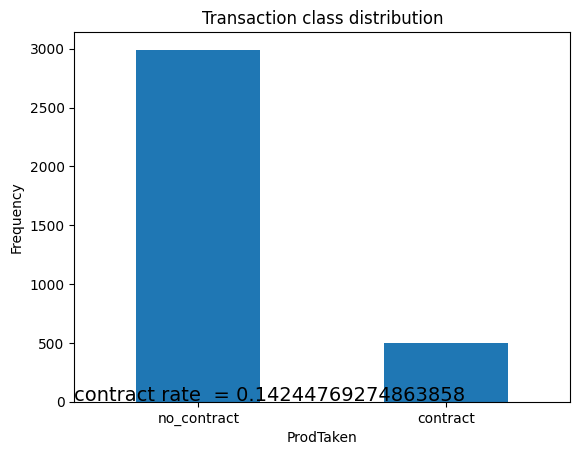

In [30]:
# 正常データと異常データの頻度を確認
import matplotlib.pyplot as plt
LABELS = ["no_contract", "contract"]

no_contract = train[train.ProdTaken == 0]
no_contract_num = no_contract['ProdTaken'].value_counts()
contract = train[train.ProdTaken == 1]
contract_num = contract['ProdTaken'].value_counts()
# 成約率を算出
rate = contract_num / (no_contract_num[0] + contract_num[1])
print(rate)
count_classes = pd.value_counts(train['ProdTaken'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("ProdTaken")
plt.ylabel("Frequency")
plt.text(-0.5, 10, 'contract rate  = {}'.format(rate[1]), fontsize = 14)

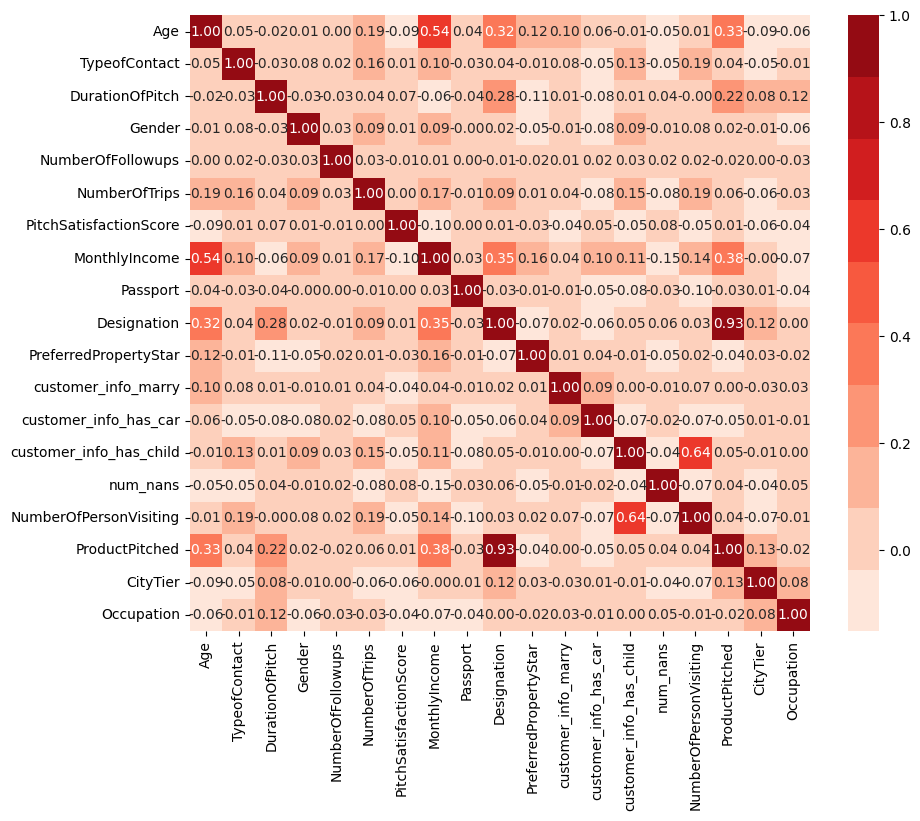

In [31]:
# 情報量が多く処理が完了しないので8月までのデータでヒートマップ算出する
import seaborn as sns
%matplotlib inline
corrs = np.corrcoef(df[features], rowvar=False)
fig,ax = plt.subplots(figsize=(10,8))

sns.heatmap(corrs, cmap=sns.color_palette('Reds', 10), annot=True,
            fmt='.2f', xticklabels=df[features].columns.tolist(), yticklabels=df[features].columns.tolist())
# input_features = ["x_customer_id","y_customer_id","x_terminal_id","y_terminal_id","distance",'TX_AMOUNT',"TX_AMOUNT-mean","mean_amount","std_amount","mean_nb_tx_per_day"]
# sns.heatmap(train_total[input_features],vmax=1, vmin=-1, center=0)
plt.savefig("heatmap.png")

In [32]:
##特徴選択

In [33]:
##特徴選択
!pip install imblearn

In [34]:

# #k近傍法のグループ数?
# knn_n_neighbors = 6


# # parameters - knn feature weights
# # 以下、kNNの学習時のパラメータ定義。regionはラベルエンコーディング、その他の量的変数は標準化、それ以外にnanの数も特徴量として使っている。
# knn_features = [
#    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
#    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
#    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
#    'region_S', 'region_T', 'region_unknown',
#    'standardscaled_popularity', 'standardscaled_duration_ms',
#    'standardscaled_acousticness', 'standardscaled_positiveness',
#    'standardscaled_danceability', 'standardscaled_loudness',
#    'standardscaled_energy', 'standardscaled_liveness',
#    'standardscaled_speechiness', 'standardscaled_instrumentalness',
#    'standardscaled_log_tempo', 'standardscaled_num_nans'
# ]

# dict_feature_weights = {}

# # regionの特長量重みを設定。
# # 以下のように重みを決めていくことができるらしい。
# # 重みですが、最初に大まかに当たりをつけ(regionは違うものが近傍データとして選ばれないくらい大きめ、popularityも他の特徴より大きめなど)、
# # 交差検証での精度を見ながら細かい調整をしています。
# for col in [
#     'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
#     'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
#     'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
#     'region_S', 'region_T', 'region_unknown'
# ]:
#     dict_feature_weights[col] = 100.0

# for col in [
#     'standardscaled_duration_ms',
#     'standardscaled_acousticness', 'standardscaled_positiveness',
#     'standardscaled_danceability', 'standardscaled_loudness',
#     'standardscaled_energy', 'standardscaled_liveness',
#     'standardscaled_speechiness', 'standardscaled_instrumentalness'
# ]:
#     dict_feature_weights[col] = 1.0

# # popularityは他の特徴よりも大きめに設定。
# dict_feature_weights["standardscaled_popularity"] = 9.0
# dict_feature_weights["standardscaled_log_tempo"] = 0.001
# dict_feature_weights["standardscaled_num_nans"] = 100.0

# # acousticnessはlightgbmで重要だったので、大きめに設定。
# dict_feature_weights["standardscaled_acousticness"] =3.0

# # k近傍法の特徴量重みをnumpy配列に変換。
# knn_feature_weights = np.array([dict_feature_weights[col] for col in knn_features])
# print(knn_feature_weights)

# # train,testデータに対して特長量エンジニアリングを行うため、合体させる。
# df_main = merge_train_test(df_train, df_test)

In [35]:
target = "ProdTaken"
df_train, df_test = split_train_test(df)
target = df_train[target]


# 学習前にdf_trainの特徴量を確認
# print(df_train.columns)
# train
# N_SPLITSは交差検証の分割数、SEED_SKFは乱数のシード値。
N_SPLITS = 5
SEED_SKF = 42
N_CLASSES = 2
np.random.seed(42)

# StratifiedKFoldでデータを分割する。
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
# oofはout of foldの略。交差検証の結果を格納するための変数。
oof = np.zeros((len(df_train), N_CLASSES))
oof_svc = np.zeros((len(df_train), N_CLASSES))
oof_mlp = np.zeros((len(df_train), N_CLASSES))
# 予測結果を格納するための変数。
predictions = np.zeros((len(df_test), N_CLASSES))
predictions_svc = np.zeros((len(df_test), N_CLASSES))
predictions_mlp = np.zeros((len(df_test), N_CLASSES))

# 特徴量の重要度を格納するための変数。
df_feature_importance = pd.DataFrame()


features_mlp = ["Age","TypeofContact","DurationOfPitch","Gender","NumberOfFollowups","NumberOfTrips","PitchSatisfactionScore","MonthlyIncome","Passport",
            # これらはワンホットエンコーディングしているので使用しない
            # "ProductPitched","PreferredPropertyStar","Designation",
            # "customer_info_marry","customer_info_has_car","customer_info_has_child",
            # ワンホットエンコーディング
            "CityTier_1","CityTier_2","CityTier_3",
            "NumberOfPersonVisiting_1","NumberOfPersonVisiting_2","NumberOfPersonVisiting_3","NumberOfPersonVisiting_4",
            "ProductPitched_0","ProductPitched_1","ProductPitched_2","ProductPitched_3",
            "PreferredPropertyStar_3","PreferredPropertyStar_4","PreferredPropertyStar_5",
            "Designation_0","Designation_1","Designation_2","Designation_3","Designation_4",
            "customer_info_marry_0","customer_info_marry_1","customer_info_marry_2",
            "customer_info_has_car_0","customer_info_has_car_1",
            "customer_info_has_child_0","customer_info_has_child_1","customer_info_has_child_2","customer_info_has_child_3","customer_info_has_child_-1",
            
            # 発生回数をカウントしているカウントエンコーディング
            "countenc_CityTier","countenc_NumberOfPersonVisiting","countenc_NumberOfFollowups","countenc_ProductPitched","countenc_NumberOfTrips","countenc_Passport","countenc_PitchSatisfactionScore","countenc_Designation","countenc_customer_info_marry","countenc_customer_info_has_car","countenc_customer_info_has_child",
            
            # ワンホットエンコーディングしているのでラベルエンコーディングはひとまず使用しない
            # "labelenc_TypeofContact","labelenc_Occupation","labelenc_CityTier","labelenc_NumberOfPersonVisiting"
            ]

features_svc = ["Age","TypeofContact","DurationOfPitch","Gender","NumberOfFollowups","NumberOfTrips","PitchSatisfactionScore","MonthlyIncome","Passport",
            # これらはワンホットエンコーディングしているので使用しない
            # "ProductPitched","PreferredPropertyStar","Designation",
            # "customer_info_marry","customer_info_has_car","customer_info_has_child",
            # ワンホットエンコーディング
            "CityTier_1","CityTier_2","CityTier_3",
            "NumberOfPersonVisiting_1","NumberOfPersonVisiting_2","NumberOfPersonVisiting_3","NumberOfPersonVisiting_4",
            "ProductPitched_0","ProductPitched_1","ProductPitched_2","ProductPitched_3",
            "PreferredPropertyStar_3","PreferredPropertyStar_4","PreferredPropertyStar_5",
            "Designation_0","Designation_1","Designation_2","Designation_3","Designation_4",
            "customer_info_marry_0","customer_info_marry_1","customer_info_marry_2",
            "customer_info_has_car_0","customer_info_has_car_1",
            "customer_info_has_child_0","customer_info_has_child_1","customer_info_has_child_2","customer_info_has_child_3","customer_info_has_child_-1",
            
            # 発生回数をカウントしているカウントエンコーディング
            "countenc_CityTier","countenc_NumberOfPersonVisiting","countenc_NumberOfFollowups","countenc_ProductPitched","countenc_NumberOfTrips","countenc_Passport","countenc_PitchSatisfactionScore","countenc_Designation","countenc_customer_info_marry","countenc_customer_info_has_car","countenc_customer_info_has_child",
            
            # ワンホットエンコーディングしているのでラベルエンコーディングはひとまず使用しない
            # "labelenc_TypeofContact","labelenc_Occupation","labelenc_CityTier","labelenc_NumberOfPersonVisiting"
            ]

# 特長量に使えるものを選択する。
# まずはラベルエンコーディングは基本使用せず、ワンホットエンコーディングを使用する。
            # これらは変換対応してそのまま使用する
features = ["Age","TypeofContact","DurationOfPitch","Gender","NumberOfFollowups","NumberOfTrips","PitchSatisfactionScore","MonthlyIncome","Passport",
            # これらはワンホットエンコーディングしているので使用しない
            # "ProductPitched","PreferredPropertyStar","Designation",
            # "customer_info_marry","customer_info_has_car","customer_info_has_child",
            # ワンホットエンコーディング
            "CityTier_1","CityTier_2","CityTier_3",
            "NumberOfPersonVisiting_1","NumberOfPersonVisiting_2","NumberOfPersonVisiting_3","NumberOfPersonVisiting_4",
            "ProductPitched_0","ProductPitched_1","ProductPitched_2","ProductPitched_3",
            "PreferredPropertyStar_3","PreferredPropertyStar_4","PreferredPropertyStar_5",
            "Designation_0","Designation_1","Designation_2","Designation_3","Designation_4",
            "customer_info_marry_0","customer_info_marry_1","customer_info_marry_2",
            "customer_info_has_car_0","customer_info_has_car_1",
            "customer_info_has_child_0","customer_info_has_child_1","customer_info_has_child_2","customer_info_has_child_3","customer_info_has_child_-1",
            
            # 発生回数をカウントしているカウントエンコーディング
            # lightGBMはありだとscore下がるのでコメントアウト
            "countenc_CityTier","countenc_NumberOfPersonVisiting","countenc_NumberOfFollowups","countenc_ProductPitched","countenc_NumberOfTrips","countenc_Passport","countenc_PitchSatisfactionScore","countenc_Designation","countenc_customer_info_marry","countenc_customer_info_has_car","countenc_customer_info_has_child",
            
            # nanの数
            "num_nans",

            # ワンホットエンコーディングしているのでラベルエンコーディングはひとまず使用しない
            # "labelenc_Occupation","labelenc_CityTier","labelenc_NumberOfPersonVisiting"
            
            # カテゴリカル変数の追加
            'Age_Categorical','MonthlyIncome_Categorical','DurationOfPitch_Categorical',

            # 成約率を使用した特長量追加
            'Occupation_closing_rate',
            'TypeofContact_closing_rate',
            'CityTier_closing_rate',
            'Gender_closing_rate',
            'NumberOfPersonVisiting_closing_rate',
            'NumberOfFollowups_closing_rate',
            'ProductPitched_closing_rate',
            'PreferredPropertyStar_closing_rate',
            'NumberOfTrips_closing_rate',
            'Passport_closing_rate',
            'PitchSatisfactionScore_closing_rate',
            'Designation_closing_rate',
            'customer_info_marry_closing_rate',
            'customer_info_has_car_closing_rate',
            'customer_info_has_child_closing_rate',
            'Age_Categorical_closing_rate',
            'MonthlyIncome_Categorical_closing_rate',
            'DurationOfPitch_Categorical_closing_rate',

            # カテゴリカル変数の組み合わせ。01のものはなくてもよさげ？
            'Age_Categorical_MonthlyIncome_Categorical',
            'Age_Categorical_DurationOfPitch_Categorical',
            'Age_Categorical_Occupation',
            'Age_Categorical_CityTier',
            'Age_Categorical_TypeofContact',
            'Age_Categorical_NumberOfPersonVisiting',
            'Age_Categorical_NumberOfFollowups',
            'Age_Categorical_ProductPitched',
            'Age_Categorical_PreferredPropertyStar',
            'Age_Categorical_Designation',
            'Age_Categorical_customer_info_marry',
            'Age_Categorical_customer_info_has_car',
            'Age_Categorical_customer_info_has_child',
            'Age_Categorical_Gender',
            'Age_Categorical_NumberOfTrips',
            'Age_Categorical_Passport',
            'Age_Categorical_PitchSatisfactionScore',
            'MonthlyIncome_Categorical_DurationOfPitch_Categorical',
            'MonthlyIncome_Categorical_Occupation',
            'MonthlyIncome_Categorical_CityTier',
            'MonthlyIncome_Categorical_TypeofContact',
            'MonthlyIncome_Categorical_NumberOfPersonVisiting',
            'MonthlyIncome_Categorical_NumberOfFollowups',
            'MonthlyIncome_Categorical_ProductPitched',
            'MonthlyIncome_Categorical_PreferredPropertyStar',
            'MonthlyIncome_Categorical_Designation',
            'MonthlyIncome_Categorical_customer_info_marry',
            'MonthlyIncome_Categorical_customer_info_has_car',
            'MonthlyIncome_Categorical_customer_info_has_child',
            'MonthlyIncome_Categorical_Gender',
            'MonthlyIncome_Categorical_NumberOfTrips',
            'MonthlyIncome_Categorical_Passport',
            'MonthlyIncome_Categorical_PitchSatisfactionScore',
            'DurationOfPitch_Categorical_Occupation',
            'DurationOfPitch_Categorical_CityTier',
            'DurationOfPitch_Categorical_TypeofContact',
            'DurationOfPitch_Categorical_NumberOfPersonVisiting',
            'DurationOfPitch_Categorical_NumberOfFollowups',
            'DurationOfPitch_Categorical_ProductPitched',
            'DurationOfPitch_Categorical_PreferredPropertyStar',
            'DurationOfPitch_Categorical_Designation',
            'DurationOfPitch_Categorical_customer_info_marry',
            'DurationOfPitch_Categorical_customer_info_has_car',
            'DurationOfPitch_Categorical_customer_info_has_child',
            'DurationOfPitch_Categorical_Gender',
            'DurationOfPitch_Categorical_NumberOfTrips',
            'DurationOfPitch_Categorical_Passport',
            'DurationOfPitch_Categorical_PitchSatisfactionScore',
            'Occupation_CityTier',
            'Occupation_TypeofContact',
            'Occupation_NumberOfPersonVisiting',
            'Occupation_NumberOfFollowups',
            'Occupation_ProductPitched',
            'Occupation_PreferredPropertyStar',
            'Occupation_Designation',
            'Occupation_customer_info_marry',
            'Occupation_customer_info_has_car',
            'Occupation_customer_info_has_child',
            'Occupation_Gender',
            'Occupation_NumberOfTrips',
            'Occupation_Passport',
            'Occupation_PitchSatisfactionScore',
            'CityTier_TypeofContact',
            'CityTier_NumberOfPersonVisiting',
            'CityTier_NumberOfFollowups',
            'CityTier_ProductPitched',
            'CityTier_PreferredPropertyStar',
            'CityTier_Designation',
            'CityTier_customer_info_marry',
            'CityTier_customer_info_has_car',
            'CityTier_customer_info_has_child',
            'CityTier_Gender',
            'CityTier_NumberOfTrips',
            'CityTier_Passport',
            'CityTier_PitchSatisfactionScore',
            'TypeofContact_NumberOfPersonVisiting',
            'TypeofContact_NumberOfFollowups',
            'TypeofContact_ProductPitched',
            'TypeofContact_PreferredPropertyStar',
            'TypeofContact_Designation',
            'TypeofContact_customer_info_marry',
            'TypeofContact_customer_info_has_car',
            'TypeofContact_customer_info_has_child',
            'TypeofContact_Gender',
            'TypeofContact_NumberOfTrips',
            'TypeofContact_Passport',
            'TypeofContact_PitchSatisfactionScore',
            'NumberOfPersonVisiting_NumberOfFollowups',
            'NumberOfPersonVisiting_ProductPitched',
            'NumberOfPersonVisiting_PreferredPropertyStar',
            'NumberOfPersonVisiting_Designation',
            'NumberOfPersonVisiting_customer_info_marry',
            'NumberOfPersonVisiting_customer_info_has_car',
            'NumberOfPersonVisiting_customer_info_has_child',
            'NumberOfPersonVisiting_Gender',
            'NumberOfPersonVisiting_NumberOfTrips',
            'NumberOfPersonVisiting_Passport',
            'NumberOfPersonVisiting_PitchSatisfactionScore',
            'NumberOfFollowups_ProductPitched',
            'NumberOfFollowups_PreferredPropertyStar',
            'NumberOfFollowups_Designation',
            'NumberOfFollowups_customer_info_marry',
            'NumberOfFollowups_customer_info_has_car',
            'NumberOfFollowups_customer_info_has_child',
            'NumberOfFollowups_Gender',
            'NumberOfFollowups_NumberOfTrips',
            'NumberOfFollowups_Passport',
            'NumberOfFollowups_PitchSatisfactionScore',
            'ProductPitched_PreferredPropertyStar',
            'ProductPitched_Designation',
            'ProductPitched_customer_info_marry',
            'ProductPitched_customer_info_has_car',
            'ProductPitched_customer_info_has_child',
            'ProductPitched_Gender',
            'ProductPitched_NumberOfTrips',
            'ProductPitched_Passport',
            'ProductPitched_PitchSatisfactionScore',
            'PreferredPropertyStar_Designation',
            'PreferredPropertyStar_customer_info_marry',
            'PreferredPropertyStar_customer_info_has_car',
            'PreferredPropertyStar_customer_info_has_child',
            'PreferredPropertyStar_Gender',
            'PreferredPropertyStar_NumberOfTrips',
            'PreferredPropertyStar_Passport',
            'PreferredPropertyStar_PitchSatisfactionScore',
            'Designation_customer_info_marry',
            'Designation_customer_info_has_car',
            'Designation_customer_info_has_child',
            'Designation_Gender',
            'Designation_NumberOfTrips',
            'Designation_Passport',
            'Designation_PitchSatisfactionScore',
            'customer_info_marry_customer_info_has_car',
            'customer_info_marry_customer_info_has_child',
            'customer_info_marry_Gender',
            'customer_info_marry_NumberOfTrips',
            'customer_info_marry_Passport',
            'customer_info_marry_PitchSatisfactionScore',
            'customer_info_has_car_customer_info_has_child',
            'customer_info_has_car_Gender',
            'customer_info_has_car_NumberOfTrips',
            'customer_info_has_car_Passport',
            'customer_info_has_car_PitchSatisfactionScore',
            'customer_info_has_child_Gender',
            'customer_info_has_child_NumberOfTrips',
            'customer_info_has_child_Passport',
            'customer_info_has_child_PitchSatisfactionScore',
            'Gender_NumberOfTrips',
            'Gender_Passport',
            'Gender_PitchSatisfactionScore',
            'NumberOfTrips_Passport',
            'NumberOfTrips_PitchSatisfactionScore',
            'Passport_PitchSatisfactionScore']
features_svc = features
features_mlp = features


In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# 特徴量を制限するかどうかのフラグ
features_limit = True

is_do_mlp_and_svc = False

# train dataのindexとvalidation dataのindexを取得して、reset_indexでindexを振り直している。drop=trueは元のindexを削除するため。
# df_train = df_train.reset_index(drop=True)
# target = target.reset_index(drop=True)
df_trn, df_val, target_trn, target_val = train_test_split(df_train, target, test_size=0.2, random_state=42)

# # make knn features
# X = df_trn[knn_features].fillna(0.0).values * knn_feature_weights
# knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target_trn)
# df_trn = pd.concat([df_trn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)

# X = df_val[knn_features].fillna(0.0).values * knn_feature_weights
# df_val = pd.concat([df_val, knn_feature_extractor.transform(X, is_train_data=False)], axis=1)

# X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
# df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)

# #  k近傍法の特徴量を追加
# for col in df_test_knn_features.columns:
#     df_test[col] = df_test_knn_features[col]

df_trn_interpolated= df_trn.copy()
df_val_interpolated = df_val.copy()
df_test_interpolated = df_test.copy()

# 量的変数の標準化。SVCやMLPに刺さる。
from sklearn.preprocessing import StandardScaler
# 標準化変換リスト
std_list = ["Age","DurationOfPitch","NumberOfFollowups","NumberOfTrips",
            "MonthlyIncome",
            # "countenc_CityTier","countenc_NumberOfPersonVisiting","countenc_NumberOfFollowups","countenc_ProductPitched","countenc_NumberOfTrips","countenc_Passport",
            # "countenc_PitchSatisfactionScore","countenc_Designation","countenc_customer_info_marry","countenc_customer_info_has_car","countenc_customer_info_has_child",
            ]
# std_list = ["Age","DurationOfPitch","NumberOfPersonVisiting","NumberOfFollowups","PreferredPropertyStar","NumberOfTrips",
#             "MonthlyIncome",
#             "countenc_CityTier","countenc_NumberOfPersonVisiting","countenc_NumberOfFollowups","countenc_ProductPitched","countenc_NumberOfTrips","countenc_Passport",
#             "countenc_PitchSatisfactionScore","countenc_Designation","countenc_customer_info_marry","countenc_customer_info_has_car","countenc_customer_info_has_child",
#             ]
scaler = StandardScaler()
scaler.fit(df_train[std_list])
df_trn_interpolated[std_list] = scaler.transform(df_trn_interpolated[std_list])
df_val_interpolated[std_list] = scaler.transform(df_val_interpolated[std_list])
df_test_interpolated[std_list] = scaler.transform(df_test_interpolated[std_list])

# 対数変換
log_list = ["Age","DurationOfPitch","NumberOfFollowups","NumberOfTrips",
            "MonthlyIncome",
            # "countenc_CityTier","countenc_NumberOfPersonVisiting","countenc_NumberOfFollowups","countenc_ProductPitched","countenc_NumberOfTrips","countenc_Passport",
            # "countenc_PitchSatisfactionScore","countenc_Designation","countenc_customer_info_marry","countenc_customer_info_has_car","countenc_customer_info_has_child",
            ]
df_trn_interpolated[log_list] = np.log(df_trn_interpolated[log_list])
df_val_interpolated[log_list] = np.log(df_val_interpolated[log_list])
df_test_interpolated[log_list] = np.log(df_test_interpolated[log_list])

# 文字列型以外の列を中央値で補完
for col in df.select_dtypes(exclude='object').columns:
    median = df_trn_interpolated[col].median()
    df_trn_interpolated[col].fillna(median, inplace=True)
    median = df_val_interpolated[col].median()
    df_val_interpolated[col].fillna(median, inplace=True)
    median = df_test_interpolated[col].median()
    df_test_interpolated[col].fillna(median, inplace=True)


# strなどは中央値で補完できないので、線形補間する。
df_trn_interpolated = df_trn_interpolated.interpolate(method='linear', limit_direction='both')
df_val_interpolated = df_val_interpolated.interpolate(method='linear', limit_direction='both')
df_test_interpolated = df_test_interpolated.interpolate(method='linear', limit_direction='both')

# 特長量をmlp用に抽出して作成
if features_limit:
    # 特長量をsvc用に抽出して作成
    df_val_interpolated_svc = df_val_interpolated[features_svc]
    df_test_interpolated_svc = df_test_interpolated[features_svc]
    df_trn_interpolated_svc = df_trn_interpolated[features_svc]

    df_val_interpolated = df_val_interpolated[features_mlp]
    df_test_interpolated = df_test_interpolated[features_mlp]
    df_trn_interpolated = df_trn_interpolated[features_mlp]


lgb_train = lgb.Dataset(
    df_trn.loc[:, features],
    label=target_trn,
    feature_name=features,
    # categorical_feature=features_categorical,
    weight=compute_sample_weight(class_weight='balanced', y=target_trn).astype('float32')
)
lgb_valid = lgb.Dataset(
    df_val.loc[:, features],
    label=target_val,
    feature_name=features,
    # categorical_feature=features_categorical,
    reference=lgb_train
)

# LightGBM
print("LightGBM start")# 以下、lightGBMの学習時のパラメータ定義
# learning_rate = [0.001, 0.01, 0.1]
# max_depth = [3, 5, 12,15,18]
# num_leaves = [2**i for i in range(2, 8)]
# min_data_in_leaf = [10,20,30, 40]
# metric = ["auc", "binary_logloss"]
learning_rate = [ 0.1]
max_depth = [3]
num_leaves = [4]
min_data_in_leaf = [30]
metric = ["auc"]
lgb_params = {
    "objective": ["binary"],
    "metric": metric,
    "learning_rate": learning_rate,
    "num_leaves": num_leaves,
    "min_data_in_leaf": min_data_in_leaf,
    "max_depth": max_depth,
    #"colsample_bytree": 1.0,
    #"feature_fraction": 1.0,
    #"bagging_freq": 0,
    #"bagging_fraction": 1.0,
    "verbosity": [0],
}
lgbm = lgb.LGBMClassifier(random_state=42)
gcv = GridSearchCV(lgbm, lgb_params, cv=5, scoring='roc_auc', return_train_score=True)
gcv.fit(df_trn[features], target_trn)

# matplotlib.pyplotを省略名pltとしてインポート 
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

# グリッドサーチの結果から、最適なパラメータを表示
print("Best parameters: ", gcv.best_params_)

# 最適なパラメータで学習したモデルを取得
num_round = 1000000
verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
evaluation_results = {} # 学習時のスコアを保存する辞書
best_model = lgb.train(
    gcv.best_params_,
    lgb_train, 
    num_round, 
    valid_sets=[lgb_train, lgb_valid], 
    callbacks=[lgb.early_stopping(stopping_rounds=50, 
                        verbose=True), # early_stopping用コールバック関数            fobj=None,            
                lgb.log_evaluation(verbose_eval),
                lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
    #feval=lgb_metric,
)

print("LightGBM end")


# SVC

print("SVC start")
if is_do_mlp_and_svc:
    # svcのグリッドサーチ
    # 条件設定
    max_score = 0
    SearchMethod = 0
    # SVC_grid = {SVC(): {"C": [0.001, 0.01, 0.1, 1, 10],
    #                     "gamma": [0.001, 0.01, 0.1, 1, 10],
    SVC_grid = {SVC(): {"C": [10],
                        "gamma": [0.01],
                        "kernel": ["rbf"],
                        "decision_function_shape": ["ovo", "ovr"],
                        "random_state": [42]
                    }}
    for model, param in SVC_grid.items():
        clf = GridSearchCV(model, param)
        clf.fit(df_trn_interpolated_svc.loc[:, features_svc], target_trn)
        pred_y = clf.predict(df_val_interpolated_svc[features_svc])
        score = roc_auc_score(target_val, pred_y)
        print("parameter is {}".format)
        print("roc_auc_score score is {}".format(score))

        if max_score < score:
            max_score = score
            best_param = clf.best_params_
            best_model_name = model.__class__.__name__


    print("ベストスコア:{}".format(max_score))
    print("モデル:{}".format(best_model_name))
    print("パラメーター:{}".format(best_param))
    # べストパラメータで学習
    classifier = SVC(C=best_param["C"],kernel=best_param["kernel"],decision_function_shape=best_param["decision_function_shape"],random_state=42,gamma=best_param["gamma"],
                    probability=True)
    print("SVC end")

    # MLP
    print("MLP start")
    # 1000、logistic、adam、0.001 、　特長制限f1: 0.56868
    # 1000、logistic、adam、0.001 、　特長全部f1: 0.62275
    learning_rate = 0.001
    mlp_learning_rate = learning_rate + np.random.random() * 0.001  # おまじない

    # # 計算に2〜３分かかります。
    results = []
    max_score = 0
    # for hidden_layer_sizes in [10, 100, 1000]:
    #     for solver in ['adam']:
    #         for activation in ['identity', 'logistic', 'tanh', 'relu']:
    #             for learning_rate_init in [0.1, 0.01, 0.001]:
    # for hidden_layer_sizes in [100]:
    #     for solver in ['adam']:
    #         for activation in ['logistic']:
    #             for learning_rate_init in [ 0.01]:
    #                 clf = MLPClassifier(max_iter=10000,
    #                     hidden_layer_sizes=(hidden_layer_sizes,), 
    #                     activation=activation, solver=solver,
    #                     learning_rate_init=learning_rate_init)
    #                 clf.fit(df_trn_interpolated.loc[:, features], target_trn)
    #                 pred_y = clf.predict_proba(df_val_interpolated[features])
    #                 score = clf.score(df_trn_interpolated.loc[:, features], target_trn)
    #                 # score = f1_score(target, pred_y.argmax(1), average="macro")
    #                 results.append([hidden_layer_sizes, activation,
    #                     solver, learning_rate_init, score])
    #                 if max_score < score:
    #                     max_score = score
    #                     best_model_mlp = clf
    print(pd.DataFrame([dat for dat in sorted(results, key=lambda f: f[4],
                reverse=True)], columns=["hidden_layer_sizes", 
                "activation", "solver", "learning_rate_init", "score"]))
    # mlpのグリッドサーチで一番scoreの良かったもののモデルを取得

    # clf = best_model_mlp
    clf = MLPClassifier(max_iter=10000,
                        hidden_layer_sizes=(100,), 
                        activation="logistic", solver='adam',
                        learning_rate_init=0.01)
    clf.fit(df_trn_interpolated.loc[:, features_mlp], target_trn)
    print("MLP end")

    if features_limit:
        classifier.fit(df_trn_interpolated_svc.loc[:, features_svc], target_trn)
        clf.fit(df_trn_interpolated.loc[:, features_mlp], target_trn)
    else:
        classifier.fit(df_trn_interpolated_svc.loc[:, features_svc], target_trn)
        clf.fit(df_trn_interpolated.loc[:, features_mlp], target_trn)

    if features_limit:
        oof_mlp = clf.predict_proba(df_val_interpolated[features_mlp])
        oof_svc = classifier.predict_proba(df_val_interpolated_svc[features_svc])
        predictions_svc = classifier.predict_proba(df_test_interpolated_svc[features_svc]) 
        predictions_mlp = clf.predict_proba(df_test_interpolated[features_mlp])
    else:
        oof_mlp = clf.predict_proba(df_val_interpolated[features_mlp])
        oof_svc = classifier.predict_proba(df_val_interpolated_svc[features_svc])
        predictions_svc = classifier.predict_proba(df_test_interpolated_svc[features_svc]) 
        predictions_mlp = clf.predict_proba(df_test_interpolated[features_mlp])


# feature importance
df_fold_importance = pd.DataFrame()
df_fold_importance["feature"] = features
df_fold_importance["importance"] = best_model.feature_importance()
df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

# lightGBM
# テストデータで予測
predictions = best_model.predict(df_test[features])
oof = best_model.predict(df_val[features])



# アンサンブルのf1も算出
# oof_final = oof*0.6 + oof_svc*0.2 + oof_mlp*0.2
# f1 = f1_score(target, oof_final.argmax(1), average="macro")
# print(f"oof ansamble f1: {f1}")


/home/hayato/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/hayato/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/hayato/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/tmp/ipykernel_17180/2399340998.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trn_interpolated[col].fillna(median, inplace=True)
/tmp/ipykernel_17180/2399340998.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the d

LightGBM start
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# lightGBMは自動で特徴選択してくれるので全部入れちゃってok
predict_lgbm = best_model.predict(df_test[features])

if is_do_mlp_and_svc:
    if features_limit:
        predict_svc = classifier.predict_proba(df_test_interpolated_svc[features_svc])
        predict_mlp = clf.predict_proba(df_test_interpolated[features_mlp])
    else:
        predict_svc = classifier.predict_proba(df_test_interpolated_svc[features_svc])
        predict_mlp = clf.predict_proba(df_test_interpolated[features_mlp])
    
    predict_svc = pd.DataFrame(predict_svc)
    predict_mlp = pd.DataFrame(predict_mlp)
    predict_mlp.head()

# それぞれの予測結果を可視化する。
predict_lgbm = pd.DataFrame(predict_lgbm)


,0,1
0,0.931232,0.068768
1,0.754975,0.245025
2,0.895190,0.104810
3,0.753188,0.246812
4,0.479368,0.520632


/tmp/ipykernel_18459/2848639111.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test["prediction"] = predictions
/tmp/ipykernel_18459/2848639111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction"] = predictions
/tmp/ipykernel_18459/2848639111.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame

CV score
  LGBM roc:  0.86483
  SVC roc:  0.53434
  MLP roc:  0.63352



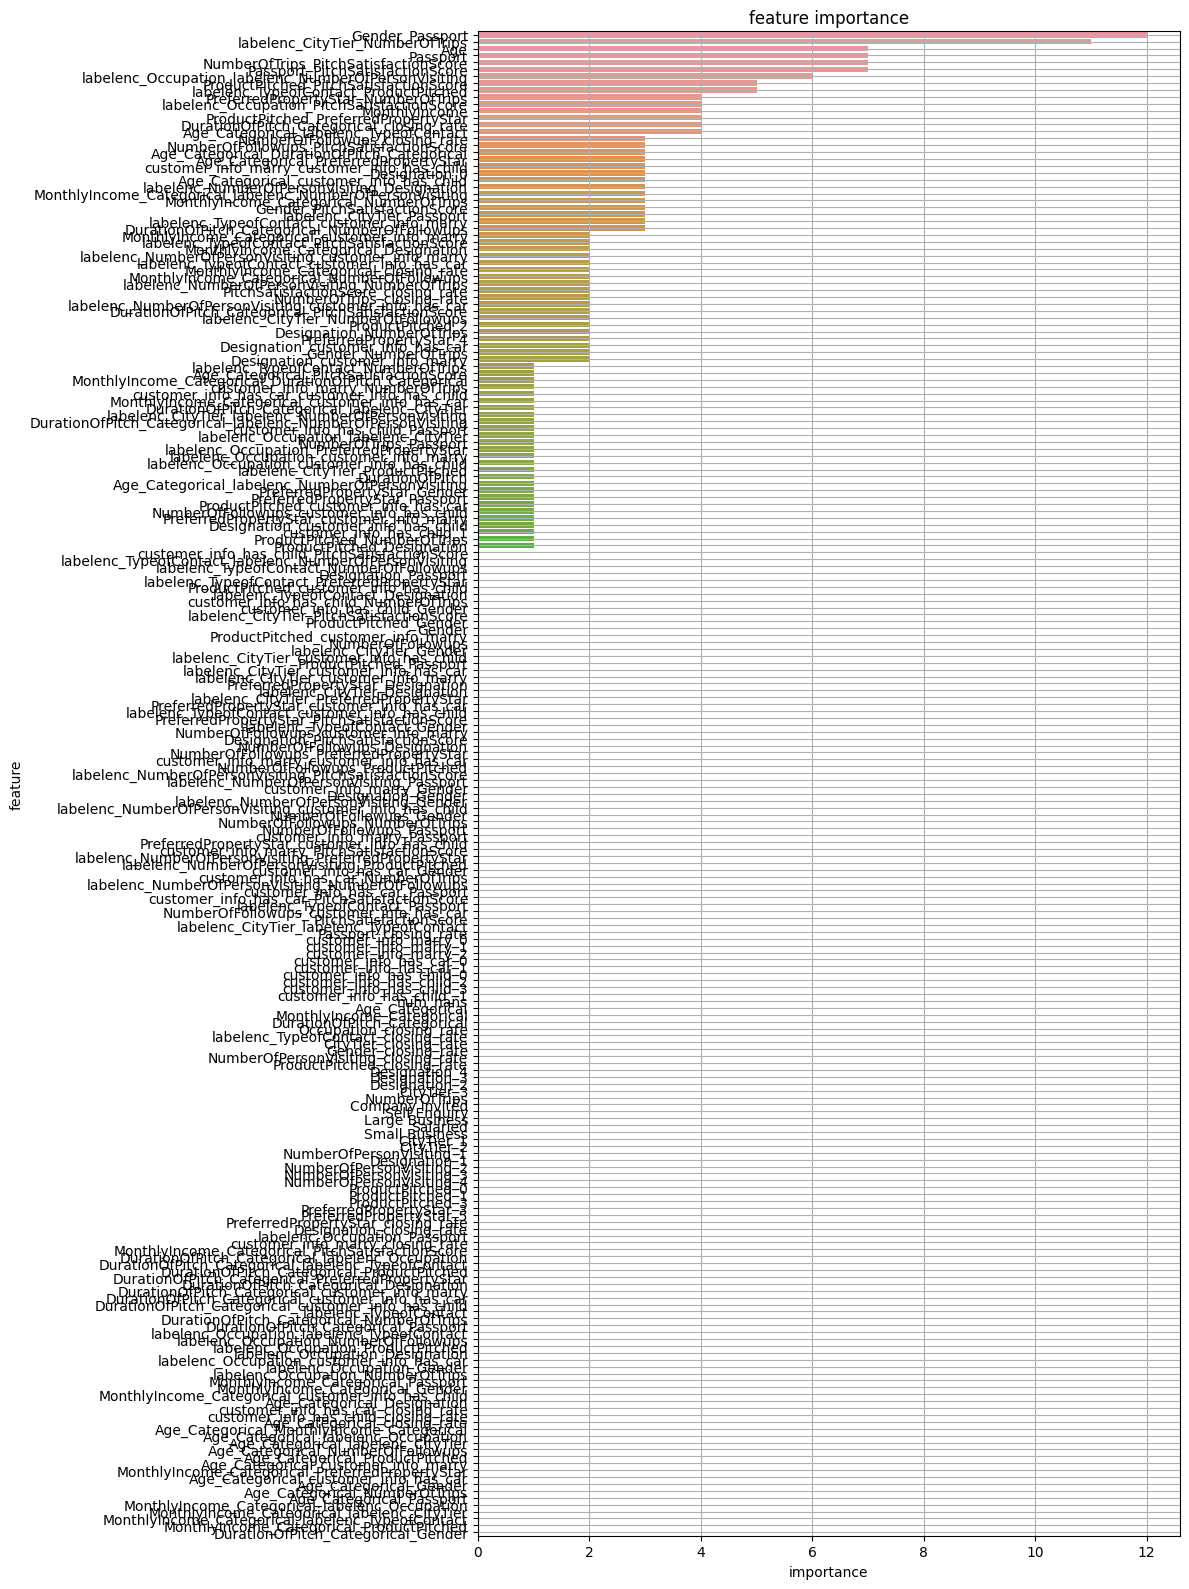

In [ ]:
df_test["prediction"] = predictions
if is_do_mlp_and_svc:
    df_test["prediction_svc"] = predictions_svc.argmax(1)
    df_test["prediction_mlp"] = predictions_mlp.argmax(1)
    auc_svc = roc_auc_score(target_val,oof_svc.argmax(1))
    auc_mlp = roc_auc_score(target_val,oof_mlp.argmax(1))
    print(f"  SVC roc: {auc_svc:8.5f}")
    print(f"  MLP roc: {auc_mlp:8.5f}")
#AUC
# aucを求める
auc = roc_auc_score(target_val,oof)

print("CV score")
print(f"  LGBM roc: {auc:8.5f}")

print()
# 結果をテキストファイルから簡単に確認できるようにtxtにf1 scoreを出力
f = open('roc_score.txt', 'w')
f.write(f"  LGBM roc: {auc:8.5f}\n")
f.write(f"  LGBM params: {lgb_params}\n")
if is_do_mlp_and_svc:
    f.write(f"  SVC roc: {auc_svc:8.5f}\n")
    f.write(f"  MLP roc: {auc_mlp:8.5f}\n")
    # それぞれのパラメータも出力
    f.write(f"  SVC params: {classifier}\n")
    f.write(f"  MLP params: {clf}\n")

#　重みも出力
f.close()

# print(classification_report(target, oof))
# print(classification_report(target, oof_svc.argmax(1)))
# print(classification_report(target, oof_mlp.argmax(1)))
plt.rcParams["font.size"] = 10

plt.figure(figsize=(12, 16))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("feature importance")
plt.grid()
plt.tight_layout()
plt.show()

# mlpとlgbmとsvcの予測結果をアンサンブルする。lightgbmの結果がいいので、重みを調整する。
# predictions_final = predictions*0.6 + predictions_mlp*0.2 + predictions_svc*0.2
# predictions_final = (predictions + predictions_mlp + predictions_svc)/3.0
# df_test["prediction_ansamble"] = predictions_final.argmax(1)

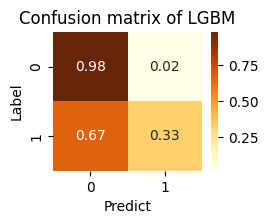

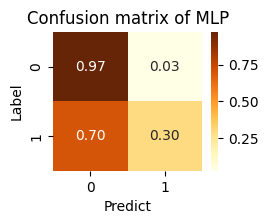

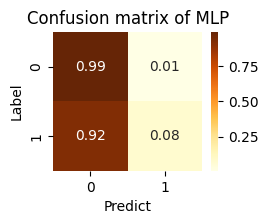

In [ ]:
def visualize_confusion_matrix(y_true,
                               pred_label,
                               height=.6,
                               labels=None,
                               title="defalut"):  # from https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')
    # タイトルを追加
    ax.set_title(title)

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

oof_label = np.where(oof > 0.5, 1, 0)
# SVCの混同行列を可視化
fig = visualize_confusion_matrix(y_true=target_val, pred_label=oof_label, title="Confusion matrix of LGBM")
fig.show()
if is_do_mlp_and_svc:
    fig = visualize_confusion_matrix(y_true=target_val, pred_label=oof_mlp.argmax(1), title="Confusion matrix of MLP")
    fig.show()
    fig = visualize_confusion_matrix(y_true=target_val, pred_label=oof_svc.argmax(1), title="Confusion matrix of MLP")
    fig.show()


In [ ]:
print(predictions)
df_submission = pd.concat([df_test["id"], pd.DataFrame(predictions)], axis=1)
df_submission.to_csv("submission.csv", header=None, index=False)
if is_do_mlp_and_svc:
    df_submission_mlp = pd.concat([df_test["id"], pd.DataFrame(predictions_mlp)], axis=1)
    df_submission_svc = pd.concat([df_test["id"], pd.DataFrame(predictions_svc)], axis=1)
    # df_submission_ansamble = pd.concat(df_test["id"], pd.DataFrame(predictions_final, axis=1))

    # make submission file
    df_submission_mlp.to_csv("submission_mlp.csv", header=None, index=False)
    df_submission_svc.to_csv("submission_svc.csv", header=None, index=False)
    # df_submission_ansamble.to_csv("submission_knn_lgbm_mlp_ansamble.csv", header=None, index=False)




[0.08872698 0.1861361  0.20928395 ... 0.65073439 0.16171776 0.01908726]


LGBM


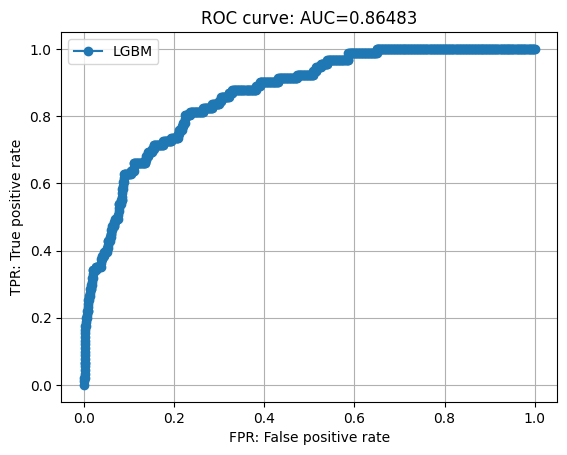

SVC


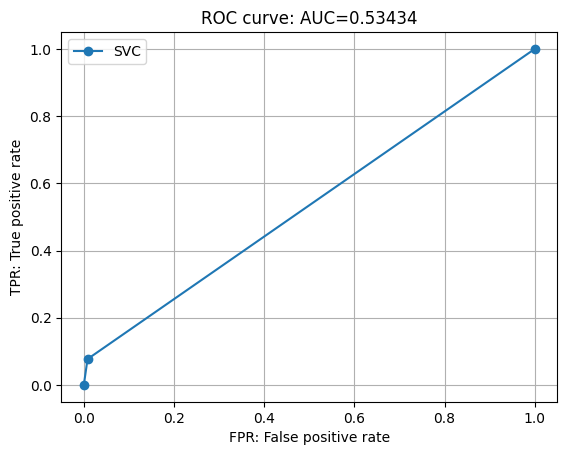

MLP


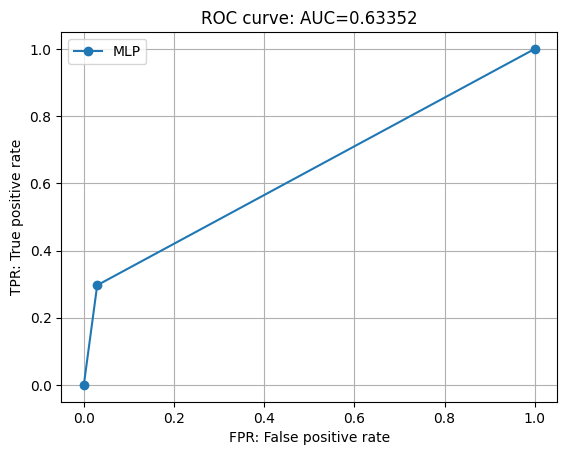

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr_all_lgb, tpr_all_lgb, thresholds_all_lgb = roc_curve(target_val, oof,
                                             drop_intermediate=False)

fpr_all_svc, tpr_all_svc, thresholds_all_svc = roc_curve(target_val, oof_svc.argmax(1),
                                             drop_intermediate=False)

fpr_all_mlp, tpr_all_mlp, thresholds_all_mlp = roc_curve(target_val, oof_mlp.argmax(1),
                                             drop_intermediate=False)

def visual_auc(fpr, tpr, thresholds, name,oof):

    plt.plot(fpr, tpr, marker='o', label=name)
    plt.xlabel('FPR: False positive rate')
    plt.ylabel('TPR: True positive rate')
    plt.grid()
    # aucを求めて図に追加
    if name == "LGBM":
        auc = roc_auc_score(target_val, oof)
    else:
        auc = roc_auc_score(target_val, oof.argmax(1))
    plt.title(f'ROC curve: AUC={auc:.5f}')
    plt.legend()
    plt.show()

print("LGBM")
visual_auc(fpr_all_lgb, tpr_all_lgb, thresholds_all_lgb, "LGBM",oof)
print("SVC")
visual_auc(fpr_all_svc, tpr_all_svc, thresholds_all_svc, "SVC",oof_svc)
print("MLP")
visual_auc(fpr_all_mlp, tpr_all_mlp, thresholds_all_mlp, "MLP",oof_mlp)
